In [1]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


# Importing Data

In [2]:
BBB_Train = pd.read_csv("BBB_LSTM_Train_ALT.csv", index_col=0)
DDD_Train = pd.read_csv("DDD_LSTM_Train_ALT.csv", index_col=0)
FFF_Train = pd.read_csv("FFF_LSTM_Train_ALT.csv", index_col=0)

BBB_Test = pd.read_csv("BBB_LSTM_Test_ALT.csv", index_col=0)
DDD_Test = pd.read_csv("DDD_LSTM_Test_ALT.csv", index_col=0)
FFF_Test = pd.read_csv("FFF_LSTM_Test_ALT.csv", index_col=0)


C:\Users\Chris\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Transforming Data

#### Remove students withdrawn from the course

In [3]:
BBB_Train = BBB_Train.loc[BBB_Train["final_result"]!= "Withdrawn",:]
DDD_Train = DDD_Train.loc[DDD_Train["final_result"]!= "Withdrawn",:]
FFF_Train = FFF_Train.loc[FFF_Train["final_result"]!= "Withdrawn",:]

BBB_Test = BBB_Test.loc[BBB_Test["final_result"]!= "Withdrawn",:]
DDD_Test = DDD_Test.loc[DDD_Test["final_result"]!= "Withdrawn",:]
FFF_Test = FFF_Test.loc[FFF_Test["final_result"]!= "Withdrawn",:]

#### Sort rows of dataframe based on id and date

In [4]:
BBB_Train = BBB_Train.sort_values(by = ['identifier','date'])
DDD_Train = DDD_Train.sort_values(by = ['identifier','date'])
FFF_Train = FFF_Train.sort_values(by = ['identifier','date'])

BBB_Test = BBB_Test.sort_values(by = ['identifier','date'])
DDD_Test = DDD_Test.sort_values(by = ['identifier','date'])
FFF_Test = FFF_Test.sort_values(by = ['identifier','date'])

In [5]:
BBB_Train.head()

,X,code_module,code_presentation,id_student,identifier,date,sum_click,asgmts,Avg_score,gender_F,...,age_band_55..,disability_N,disability_Y,year_2013,year_2014,semester_B,semester_J,num_of_prev_attempts,studied_credits,final_result
360684,360684,BBB,2013B,1008675,BBB 2013B 1008675,-25,0,0,0.0,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360685,360685,BBB,2013B,1008675,BBB 2013B 1008675,-24,0,0,0.0,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360686,360686,BBB,2013B,1008675,BBB 2013B 1008675,-23,0,0,0.0,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360687,360687,BBB,2013B,1008675,BBB 2013B 1008675,-22,0,0,0.0,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360688,360688,BBB,2013B,1008675,BBB 2013B 1008675,-21,0,0,0.0,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass


In [6]:
BBB_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086444 entries, 360684 to 908300
Data columns (total 39 columns):
X                                                1086444 non-null int64
code_module                                      1086444 non-null object
code_presentation                                1086444 non-null object
id_student                                       1086444 non-null int64
identifier                                       1086444 non-null object
date                                             1086444 non-null int64
sum_click                                        1086444 non-null int64
asgmts                                           1086444 non-null int64
Avg_score                                        1086444 non-null float64
gender_F                                         1086444 non-null int64
gender_M                                         1086444 non-null int64
highest_education_Lower.Than.A.Level             1086444 non-null int64
highest_educat

In [7]:
BBB_LSTM_Train = BBB_Train.loc[:,["code_presentation","identifier","date","sum_click", "asgmts", "Avg_score", "final_result"]]
BBB_LSTM_Test = BBB_Test.loc[:,["code_presentation","identifier","date","sum_click", "asgmts", "Avg_score", "final_result"]]

DDD_LSTM_Train = DDD_Train.loc[:,["code_presentation","identifier","date","sum_click", "asgmts", "Avg_score", "final_result"]]
DDD_LSTM_Test = DDD_Test.loc[:,["code_presentation","identifier","date","sum_click", "asgmts", "Avg_score", "final_result"]]

FFF_LSTM_Train = FFF_Train.loc[:,["code_presentation","identifier","date","sum_click", "asgmts", "Avg_score", "final_result"]]
FFF_LSTM_Test = FFF_Test.loc[:,["code_presentation","identifier","date","sum_click", "asgmts", "Avg_score", "final_result"]]

In [8]:
BBB_LSTM_Train.head()

,code_presentation,identifier,date,sum_click,asgmts,Avg_score,final_result
360684,2013B,BBB 2013B 1008675,-25,0,0,0.0,Pass
360685,2013B,BBB 2013B 1008675,-24,0,0,0.0,Pass
360686,2013B,BBB 2013B 1008675,-23,0,0,0.0,Pass
360687,2013B,BBB 2013B 1008675,-22,0,0,0.0,Pass
360688,2013B,BBB 2013B 1008675,-21,0,0,0.0,Pass


In [9]:
BBB_LSTM_Train.shape

(1086444, 7)

In [10]:
BBB_LSTM_Train.loc[:,["sum_click","asgmts","Avg_score"]][BBB_LSTM_Train["sum_click"]!=-1].shape

(1018336, 3)

#### Calculate percentile-groups based on a student's average daily clicks in a certain decile each semester
Necessary to alleviate effects from structural changes between semesters

In [11]:
BBB_LSTM_Train["Rank_Clicks"] = 0
DDD_LSTM_Train["Rank_Clicks"] = 0
FFF_LSTM_Train["Rank_Clicks"] = 0

BBB_LSTM_Test["Rank_Clicks"] = 0
DDD_LSTM_Test["Rank_Clicks"] = 0
FFF_LSTM_Test["Rank_Clicks"] = 0

BBB_LSTM_Train["Rank_Clicks"][BBB_LSTM_Train.sum_click == -1] = -1
DDD_LSTM_Train["Rank_Clicks"][DDD_LSTM_Train.sum_click == -1] = -1
FFF_LSTM_Train["Rank_Clicks"][FFF_LSTM_Train.sum_click == -1] = -1

BBB_LSTM_Test["Rank_Clicks"][BBB_LSTM_Test.sum_click == -1] = -1
DDD_LSTM_Test["Rank_Clicks"][DDD_LSTM_Test.sum_click == -1] = -1
FFF_LSTM_Test["Rank_Clicks"][FFF_LSTM_Test.sum_click == -1] = -1

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Ch

In [12]:
Semesters_Train = BBB_LSTM_Train.code_presentation.unique()
dfs_Train = list([BBB_LSTM_Train, DDD_LSTM_Train, FFF_LSTM_Train])
Semesters_Test = BBB_LSTM_Test.code_presentation.unique()
dfs_Test = list([BBB_LSTM_Test, DDD_LSTM_Test, FFF_LSTM_Test])

In [13]:
Percentiles = [0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80, 0.85,0.90,0.95,1]

In [14]:
percentile_limit = [0]

In [15]:
for i in range(0,len(dfs_Train)):
    for j in range(0,len(Semesters_Train)):
        for d in dfs_Train[i]["date"].unique():
            for p in range(0,len(Percentiles)):
                Rowclicks = dfs_Train[i]["sum_click"][dfs_Train[i].sum_click!=-1][dfs_Train[i].date == d][dfs_Train[i].code_presentation == Semesters_Train[j]][dfs_Train[i].sum_click>0]
                
                if Rowclicks.empty == False:
                    percentile_limit.append(np.percentile(Rowclicks,Percentiles[p]*100))
                    
                    dfs_Train[i]["Rank_Clicks"][(dfs_Train[i].sum_click != -1) &
                                                (dfs_Train[i].code_presentation == Semesters_Train[j]) &
                                                (dfs_Train[i].date == d) &
                                                (dfs_Train[i]["sum_click"] > percentile_limit[p]) &
                                                (dfs_Train[i]["sum_click"] <= percentile_limit[p+1])] = Percentiles[p]
                    
        print("Presentation " + str(j+1) + " out of "+ str(3) + " of course " + str(i+1))


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Presentation 1 out of 3 of course 1
Presentation 2 out of 3 of course 1
Presentation 3 out of 3 of course 1


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Presentation 1 out of 3 of course 2
Presentation 2 out of 3 of course 2
Presentation 3 out of 3 of course 2


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Presentation 1 out of 3 of course 3
Presentation 2 out of 3 of course 3
Presentation 3 out of 3 of course 3


In [16]:
for i in range(0,len(dfs_Test)):
    for j in range(0,len(Semesters_Test)):
        for d in dfs_Test[i]["date"].unique():
            for p in range(0,len(Percentiles)):
                Rowclicks = dfs_Test[i]["sum_click"][dfs_Test[i].sum_click!=-1][dfs_Test[i].date == d][dfs_Test[i].code_presentation == Semesters_Test[j]][dfs_Test[i].sum_click>0]
                
                if Rowclicks.empty == False:
                    percentile_limit.append(np.percentile(Rowclicks,Percentiles[p]*100))
                    
                    dfs_Test[i]["Rank_Clicks"][(dfs_Test[i].sum_click != -1) &
                                               (dfs_Test[i].code_presentation == Semesters_Test[j]) & 
                                               (dfs_Test[i].date == d) &
                                               (dfs_Test[i]["sum_click"] > percentile_limit[p]) &
                                               (dfs_Test[i]["sum_click"] <= percentile_limit[p+1])] = Percentiles[p]
                    
                    
        print("Presentation " + str(j+1) + " out of "+ str(4) + " of course " + str(i+1))

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Presentation 1 out of 4 of course 1


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Presentation 1 out of 4 of course 2


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Presentation 1 out of 4 of course 3


In [17]:
BBB_LSTM_Train["sum_click"] = BBB_LSTM_Train["Rank_Clicks"]
DDD_LSTM_Train["sum_click"] = DDD_LSTM_Train["Rank_Clicks"]
FFF_LSTM_Train["sum_click"] = FFF_LSTM_Train["Rank_Clicks"]

BBB_LSTM_Test["sum_click"] = BBB_LSTM_Test["Rank_Clicks"]
DDD_LSTM_Test["sum_click"] = DDD_LSTM_Test["Rank_Clicks"]
FFF_LSTM_Test["sum_click"] = FFF_LSTM_Test["Rank_Clicks"]

BBB_LSTM_Train = BBB_LSTM_Train.drop('Rank_Clicks',1)
DDD_LSTM_Train = DDD_LSTM_Train.drop('Rank_Clicks',1)
FFF_LSTM_Train = FFF_LSTM_Train.drop('Rank_Clicks',1)

BBB_LSTM_Test = BBB_LSTM_Test.drop('Rank_Clicks',1)
DDD_LSTM_Test = DDD_LSTM_Test.drop('Rank_Clicks',1)
FFF_LSTM_Test = FFF_LSTM_Test.drop('Rank_Clicks',1)

In [18]:
BBB_LSTM_Train.head(n=100)

,code_presentation,identifier,date,sum_click,asgmts,Avg_score,final_result
360684,2013B,BBB 2013B 1008675,-25,0.00,0,0.00,Pass
360685,2013B,BBB 2013B 1008675,-24,0.00,0,0.00,Pass
360686,2013B,BBB 2013B 1008675,-23,0.00,0,0.00,Pass
360687,2013B,BBB 2013B 1008675,-22,0.00,0,0.00,Pass
360688,2013B,BBB 2013B 1008675,-21,0.00,0,0.00,Pass
360689,2013B,BBB 2013B 1008675,-20,0.00,0,0.00,Pass
360690,2013B,BBB 2013B 1008675,-19,0.00,0,0.00,Pass
360691,2013B,BBB 2013B 1008675,-18,0.00,0,0.00,Pass
360692,2013B,BBB 2013B 1008675,-17,0.00,0,0.00,Pass
360693,2013B,BBB 2013B 1008675,-16,0.00,0,0.00,Pass


In [19]:
Semesters_Train = BBB_LSTM_Train.code_presentation.unique()
dfs_Train = list([BBB_LSTM_Train, DDD_LSTM_Train, FFF_LSTM_Train])
Semesters_Test = BBB_LSTM_Test.code_presentation.unique()
dfs_Test = list([BBB_LSTM_Test, DDD_LSTM_Test, FFF_LSTM_Test])

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))

for i in range(0,len(dfs_Train)):
    for j in range(0,len(Semesters_Train)):
        scaler.fit(dfs_Train[i].loc[(dfs_Train[i]["code_presentation"]==Semesters_Train[j]) & (dfs_Train[i]["asgmts"]!=-1), ["asgmts","Avg_score"]])
        dfs_Train[i].loc[(dfs_Train[i]["code_presentation"]==Semesters_Train[j]) & (dfs_Train[i]["asgmts"]!=-1), ["asgmts","Avg_score"]] = scaler.transform(dfs_Train[i].loc[(dfs_Train[i]["code_presentation"]==Semesters_Train[j]) & (dfs_Train[i]["asgmts"]!=-1), ["asgmts","Avg_score"]])


for i in range(0,len(dfs_Test)):
    for j in range(0,len(Semesters_Test)):
        scaler.fit(dfs_Test[i].loc[(dfs_Test[i]["code_presentation"]==Semesters_Test[j])  & (dfs_Test[i]["asgmts"]!=-1), ["asgmts","Avg_score"]])
        dfs_Test[i].loc[(dfs_Test[i]["code_presentation"]==Semesters_Test[j]) & (dfs_Test[i]["asgmts"]!=-1), ["asgmts","Avg_score"]] = scaler.transform(dfs_Test[i].loc[(dfs_Test[i]["code_presentation"]==Semesters_Test[j])  & (dfs_Test[i]["asgmts"]!=-1), ["asgmts","Avg_score"]])

In [22]:
BBB_Train.head(n=100)

,X,code_module,code_presentation,id_student,identifier,date,sum_click,asgmts,Avg_score,gender_F,...,age_band_55..,disability_N,disability_Y,year_2013,year_2014,semester_B,semester_J,num_of_prev_attempts,studied_credits,final_result
360684,360684,BBB,2013B,1008675,BBB 2013B 1008675,-25,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360685,360685,BBB,2013B,1008675,BBB 2013B 1008675,-24,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360686,360686,BBB,2013B,1008675,BBB 2013B 1008675,-23,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360687,360687,BBB,2013B,1008675,BBB 2013B 1008675,-22,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360688,360688,BBB,2013B,1008675,BBB 2013B 1008675,-21,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360689,360689,BBB,2013B,1008675,BBB 2013B 1008675,-20,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360690,360690,BBB,2013B,1008675,BBB 2013B 1008675,-19,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360691,360691,BBB,2013B,1008675,BBB 2013B 1008675,-18,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360692,360692,BBB,2013B,1008675,BBB 2013B 1008675,-17,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass
360693,360693,BBB,2013B,1008675,BBB 2013B 1008675,-16,0,0,0.00,1,...,0,1,0,1,0,1,0,0.0,0.0,Pass


#### Normalize variables that are not -1 (-1 is padding)

In [23]:
BBB_LSTM_Train.shape

(1086444, 7)

In [24]:
BBB_LSTM_Train.head(n=100)

,code_presentation,identifier,date,sum_click,asgmts,Avg_score,final_result
360684,2013B,BBB 2013B 1008675,-25,0.00,0.000000,0.0000,Pass
360685,2013B,BBB 2013B 1008675,-24,0.00,0.000000,0.0000,Pass
360686,2013B,BBB 2013B 1008675,-23,0.00,0.000000,0.0000,Pass
360687,2013B,BBB 2013B 1008675,-22,0.00,0.000000,0.0000,Pass
360688,2013B,BBB 2013B 1008675,-21,0.00,0.000000,0.0000,Pass
360689,2013B,BBB 2013B 1008675,-20,0.00,0.000000,0.0000,Pass
360690,2013B,BBB 2013B 1008675,-19,0.00,0.000000,0.0000,Pass
360691,2013B,BBB 2013B 1008675,-18,0.00,0.000000,0.0000,Pass
360692,2013B,BBB 2013B 1008675,-17,0.00,0.000000,0.0000,Pass
360693,2013B,BBB 2013B 1008675,-16,0.00,0.000000,0.0000,Pass


In [25]:
BBB_AUX_Train = pd.concat((BBB_Train.loc[:,"identifier"],BBB_Train.loc[:,"gender_F":"final_result"]), axis = 1)
BBB_AUX_Test = pd.concat((BBB_Test.loc[:,"identifier"],BBB_Test.loc[:,"gender_F":"final_result"]), axis = 1)

DDD_AUX_Train = pd.concat((DDD_Train.loc[:,"identifier"],DDD_Train.loc[:,"gender_F":"final_result"]), axis = 1)
DDD_AUX_Test = pd.concat((DDD_Test.loc[:,"identifier"],DDD_Test.loc[:,"gender_F":"final_result"]), axis = 1)

FFF_AUX_Train = pd.concat((FFF_Train.loc[:,"identifier"],FFF_Train.loc[:,"gender_F":"final_result"]), axis = 1)
FFF_AUX_Test = pd.concat((FFF_Test.loc[:,"identifier"],FFF_Test.loc[:,"gender_F":"final_result"]), axis = 1)

In [26]:
BBB_AUX_Train = BBB_AUX_Train.drop_duplicates()
BBB_AUX_Test = BBB_AUX_Test.drop_duplicates()

DDD_AUX_Train = DDD_AUX_Train.drop_duplicates()
DDD_AUX_Test = DDD_AUX_Test.drop_duplicates()

FFF_AUX_Train = FFF_AUX_Train.drop_duplicates()
FFF_AUX_Test = FFF_AUX_Test.drop_duplicates()

In [27]:
FFF_AUX_Train.shape

(3659, 31)

In [28]:
#scaler = MinMaxScaler(feature_range=(0,1))

#dfs_AUX_Train = list([BBB_AUX_Train, DDD_AUX_Train, FFF_AUX_Train])
#dfs_AUX_Test = list([BBB_AUX_Test, DDD_AUX_Test, FFF_AUX_Test])

#for i in range(0,len(dfs_AUX_Train)):
#    scaler.fit(dfs_AUX_Train[i].loc[:,["num_of_prev_attempts","studied_credits"]])
#    dfs_AUX_Train[i].loc[:,["num_of_prev_attempts","studied_credits"]]= scaler.transform(dfs_AUX_Train[i].loc[:,["num_of_prev_attempts","studied_credits"]])
    
#for i in range(0,len(dfs_AUX_Test)):
#    scaler.fit(dfs_AUX_Test[i].loc[:,["num_of_prev_attempts","studied_credits"]])
#   dfs_AUX_Test[i].loc[:,["num_of_prev_attempts","studied_credits"]]= scaler.transform(dfs_AUX_Test[i].loc[:,["num_of_prev_attempts","studied_credits"]])

In [29]:
#BBB_AUX_Train = dfs_AUX_Train[0]
#DDD_AUX_Train = dfs_AUX_Train[1]
#FFF_AUX_Train = dfs_AUX_Train[2]

#BBB_AUX_Test = dfs_AUX_Test[0]
#DDD_AUX_Test = dfs_AUX_Test[1]
#FFF_AUX_Test = dfs_AUX_Test[2]

In [30]:
BBB_LSTM_Train_List = BBB_LSTM_Train['identifier'].unique().tolist()
BBB_LSTM_Test_List = BBB_LSTM_Test['identifier'].unique().tolist()

DDD_LSTM_Train_List = DDD_LSTM_Train['identifier'].unique().tolist()
DDD_LSTM_Test_List = DDD_LSTM_Test['identifier'].unique().tolist()

FFF_LSTM_Train_List = FFF_LSTM_Train['identifier'].unique().tolist()
FFF_LSTM_Test_List = FFF_LSTM_Test['identifier'].unique().tolist()

In [31]:
BBB_LSTM_Train_3D = np.asarray(list(BBB_LSTM_Train.groupby('identifier').apply(pd.DataFrame.as_matrix))) 
BBB_LSTM_Test_3D = np.asarray(list(BBB_LSTM_Test.groupby('identifier').apply(pd.DataFrame.as_matrix)))

DDD_LSTM_Train_3D = np.asarray(list(DDD_LSTM_Train.groupby('identifier').apply(pd.DataFrame.as_matrix))) 
DDD_LSTM_Test_3D = np.asarray(list(DDD_LSTM_Test.groupby('identifier').apply(pd.DataFrame.as_matrix)))

FFF_LSTM_Train_3D = np.asarray(list(FFF_LSTM_Train.groupby('identifier').apply(pd.DataFrame.as_matrix))) 
FFF_LSTM_Test_3D = np.asarray(list(FFF_LSTM_Test.groupby('identifier').apply(pd.DataFrame.as_matrix)))

In [32]:
BBB_LSTM_Train_3D

array([[['2013B', 'BBB 2013B 1008675', -25, ..., 0.0, 0.0, 'Pass'],
        ['2013B', 'BBB 2013B 1008675', -24, ..., 0.0, 0.0, 'Pass'],
        ['2013B', 'BBB 2013B 1008675', -23, ..., 0.0, 0.0, 'Pass'],
        ..., 
        ['2013B', 'BBB 2013B 1008675', 265, ..., -1.0, -1.0, 'Pass'],
        ['2013B', 'BBB 2013B 1008675', 266, ..., -1.0, -1.0, 'Pass'],
        ['2013B', 'BBB 2013B 1008675', 267, ..., -1.0, -1.0, 'Pass']],

       [['2013B', 'BBB 2013B 104054', -25, ..., 0.0, 0.0, 'Distinction'],
        ['2013B', 'BBB 2013B 104054', -24, ..., 0.0, 0.0, 'Distinction'],
        ['2013B', 'BBB 2013B 104054', -23, ..., 0.0, 0.0, 'Distinction'],
        ..., 
        ['2013B', 'BBB 2013B 104054', 265, ..., -1.0, -1.0, 'Distinction'],
        ['2013B', 'BBB 2013B 104054', 266, ..., -1.0, -1.0, 'Distinction'],
        ['2013B', 'BBB 2013B 104054', 267, ..., -1.0, -1.0, 'Distinction']],

       [['2013B', 'BBB 2013B 108377', -25, ..., 0.0, 0.0, 'Pass'],
        ['2013B', 'BBB 2013B 108377',

In [33]:
BBB_Train_3D = np.delete(BBB_LSTM_Train_3D,[0,1,2,6],axis=2)
BBB_Test_3D = np.delete(BBB_LSTM_Test_3D,[0,1,2,6],axis=2)

DDD_Train_3D = np.delete(DDD_LSTM_Train_3D,[0,1,2,6],axis=2)
DDD_Test_3D = np.delete(DDD_LSTM_Test_3D,[0,1,2,6],axis=2)

FFF_Train_3D = np.delete(FFF_LSTM_Train_3D,[0,1,2,6],axis=2)
FFF_Test_3D = np.delete(FFF_LSTM_Test_3D,[0,1,2,6],axis=2)

In [34]:
BBB_Train_3D

array([[[0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        ..., 
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0]],

       [[0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        ..., 
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0]],

       [[0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        ..., 
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0]],

       ..., 
       [[0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        ..., 
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0]],

       [[0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        ..., 
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0]],

       [[0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0],
        ..., 
        [-1.0, -1.0, -1

In [35]:
BBB_Train_Targets = BBB_AUX_Train.iloc[:,-1]
DDD_Train_Targets = DDD_AUX_Train.iloc[:,-1]
FFF_Train_Targets = FFF_AUX_Train.iloc[:,-1]

BBB_Test_Targets = BBB_AUX_Test.iloc[:,-1]
DDD_Test_Targets = DDD_AUX_Test.iloc[:,-1]
FFF_Test_Targets = FFF_AUX_Test.iloc[:,-1]

In [36]:
BBB_AUX_Train = BBB_AUX_Train.iloc[:,1:30]
DDD_AUX_Train = DDD_AUX_Train.iloc[:,1:30]
FFF_AUX_Train = FFF_AUX_Train.iloc[:,1:30]

BBB_AUX_Test = BBB_AUX_Test.iloc[:,1:30]
DDD_AUX_Test = DDD_AUX_Test.iloc[:,1:30]
FFF_AUX_Test = FFF_AUX_Test.iloc[:,1:30]

#### Number of students in the courses across all 4 semesters

#### Convert dataframes into 2D arrays

#### Normalize variables

#### Reshape 2D arrays to 3D arrays
Format : samples (students), timesteps (deciles), features (clicks & assignments)

### Exclude timestep(s) in sequences to be able to build the models for multiple points in time

In [37]:
BBB_Train_Targets_1D = np.array(BBB_Train_Targets)
DDD_Train_Targets_1D = np.array(DDD_Train_Targets)
FFF_Train_Targets_1D = np.array(FFF_Train_Targets)

BBB_Test_Targets_1D = np.array(BBB_Test_Targets)
DDD_Test_Targets_1D = np.array(DDD_Test_Targets)
FFF_Test_Targets_1D = np.array(FFF_Test_Targets)


In [38]:
BBB_Train_Targets_1D[BBB_Train_Targets_1D == "Fail"] = 0
BBB_Train_Targets_1D[BBB_Train_Targets_1D == "Pass"] = 1
BBB_Train_Targets_1D[BBB_Train_Targets_1D == "Distinction"] = 1

DDD_Train_Targets_1D[DDD_Train_Targets_1D == "Fail"] = 0
DDD_Train_Targets_1D[DDD_Train_Targets_1D == "Pass"] = 1
DDD_Train_Targets_1D[DDD_Train_Targets_1D == "Distinction"] = 1

FFF_Train_Targets_1D[FFF_Train_Targets_1D == "Fail"] = 0
FFF_Train_Targets_1D[FFF_Train_Targets_1D == "Pass"] = 1
FFF_Train_Targets_1D[FFF_Train_Targets_1D == "Distinction"] = 1

BBB_Test_Targets_1D[BBB_Test_Targets_1D == "Fail"] = 0
BBB_Test_Targets_1D[BBB_Test_Targets_1D == "Pass"] = 1
BBB_Test_Targets_1D[BBB_Test_Targets_1D == "Distinction"] = 1

DDD_Test_Targets_1D[DDD_Test_Targets_1D == "Fail"] = 0
DDD_Test_Targets_1D[DDD_Test_Targets_1D == "Pass"] = 1
DDD_Test_Targets_1D[DDD_Test_Targets_1D == "Distinction"] = 1

FFF_Test_Targets_1D[FFF_Test_Targets_1D == "Fail"] = 0
FFF_Test_Targets_1D[FFF_Test_Targets_1D == "Pass"] = 1
FFF_Test_Targets_1D[FFF_Test_Targets_1D == "Distinction"] = 1

In [39]:
BBB_Train_Targets_1D = BBB_Train_Targets_1D.astype('int64')
DDD_Train_Targets_1D = DDD_Train_Targets_1D.astype('int64')
FFF_Train_Targets_1D = FFF_Train_Targets_1D.astype('int64')

BBB_Test_Targets_1D = BBB_Test_Targets_1D.astype('int64')
DDD_Test_Targets_1D = DDD_Test_Targets_1D.astype('int64')
FFF_Test_Targets_1D = FFF_Test_Targets_1D.astype('int64')

In [40]:
print(FFF_Train_Targets_1D.shape)

(3659,)


In [41]:
print(FFF_Train_3D.shape)

(3659, 293, 3)


In [42]:
print(FFF_AUX_Train.shape)

(3659, 29)


#### Exclude timestep(s) in sequences to be able to build the models for multiple points in time

In [43]:
Precourse_days = 25
cut_off = round((BBB_Train_3D.shape[1] - Precourse_days)/10)

In [44]:
BBB_Train_Decile0 = BBB_Train_3D[:,0:Precourse_days,:]
BBB_Train_Decile1 = BBB_Train_3D[:,0:(Precourse_days+cut_off),:]
BBB_Train_Decile2 = BBB_Train_3D[:,0:(Precourse_days+cut_off*2),:]
BBB_Train_Decile3 = BBB_Train_3D[:,0:(Precourse_days+cut_off*3),:]
BBB_Train_Decile4 = BBB_Train_3D[:,0:(Precourse_days+cut_off*4),:]
BBB_Train_Decile5 = BBB_Train_3D[:,0:(Precourse_days+cut_off*5),:]
BBB_Train_Decile6 = BBB_Train_3D[:,0:(Precourse_days+cut_off*6),:]
BBB_Train_Decile7 = BBB_Train_3D[:,0:(Precourse_days+cut_off*7),:]
BBB_Train_Decile8 = BBB_Train_3D[:,0:(Precourse_days+cut_off*8),:]
BBB_Train_Decile9 = BBB_Train_3D[:,0:(Precourse_days+cut_off*9),:]
BBB_Train_Decile10 = BBB_Train_3D

BBB_Test_Decile0 = BBB_Test_3D[:,0:Precourse_days,:]
BBB_Test_Decile1 = BBB_Test_3D[:,0:(Precourse_days+cut_off),:]
BBB_Test_Decile2 = BBB_Test_3D[:,0:(Precourse_days+cut_off*2),:]
BBB_Test_Decile3 = BBB_Test_3D[:,0:(Precourse_days+cut_off*3),:]
BBB_Test_Decile4 = BBB_Test_3D[:,0:(Precourse_days+cut_off*4),:]
BBB_Test_Decile5 = BBB_Test_3D[:,0:(Precourse_days+cut_off*5),:]
BBB_Test_Decile6 = BBB_Test_3D[:,0:(Precourse_days+cut_off*6),:]
BBB_Test_Decile7 = BBB_Test_3D[:,0:(Precourse_days+cut_off*7),:]
BBB_Test_Decile8 = BBB_Test_3D[:,0:(Precourse_days+cut_off*8),:]
BBB_Test_Decile9 = BBB_Test_3D[:,0:(Precourse_days+cut_off*9),:]
BBB_Test_Decile10 = BBB_Test_3D

In [45]:
DDD_Train_Decile0 = DDD_Train_3D[:,0:Precourse_days,:]
DDD_Train_Decile1 = DDD_Train_3D[:,0:(Precourse_days+cut_off),:]
DDD_Train_Decile2 = DDD_Train_3D[:,0:(Precourse_days+cut_off*2),:]
DDD_Train_Decile3 = DDD_Train_3D[:,0:(Precourse_days+cut_off*3),:]
DDD_Train_Decile4 = DDD_Train_3D[:,0:(Precourse_days+cut_off*4),:]
DDD_Train_Decile5 = DDD_Train_3D[:,0:(Precourse_days+cut_off*5),:]
DDD_Train_Decile6 = DDD_Train_3D[:,0:(Precourse_days+cut_off*6),:]
DDD_Train_Decile7 = DDD_Train_3D[:,0:(Precourse_days+cut_off*7),:]
DDD_Train_Decile8 = DDD_Train_3D[:,0:(Precourse_days+cut_off*8),:]
DDD_Train_Decile9 = DDD_Train_3D[:,0:(Precourse_days+cut_off*9),:]
DDD_Train_Decile10 = DDD_Train_3D

DDD_Test_Decile0 = DDD_Test_3D[:,0:Precourse_days,:]
DDD_Test_Decile1 = DDD_Test_3D[:,0:(Precourse_days+cut_off),:]
DDD_Test_Decile2 = DDD_Test_3D[:,0:(Precourse_days+cut_off*2),:]
DDD_Test_Decile3 = DDD_Test_3D[:,0:(Precourse_days+cut_off*3),:]
DDD_Test_Decile4 = DDD_Test_3D[:,0:(Precourse_days+cut_off*4),:]
DDD_Test_Decile5 = DDD_Test_3D[:,0:(Precourse_days+cut_off*5),:]
DDD_Test_Decile6 = DDD_Test_3D[:,0:(Precourse_days+cut_off*6),:]
DDD_Test_Decile7 = DDD_Test_3D[:,0:(Precourse_days+cut_off*7),:]
DDD_Test_Decile8 = DDD_Test_3D[:,0:(Precourse_days+cut_off*8),:]
DDD_Test_Decile9 = DDD_Test_3D[:,0:(Precourse_days+cut_off*9),:]
DDD_Test_Decile10 = DDD_Test_3D

In [46]:
FFF_Train_Decile0 = FFF_Train_3D[:,0:Precourse_days,:]
FFF_Train_Decile1 = FFF_Train_3D[:,0:(Precourse_days+cut_off),:]
FFF_Train_Decile2 = FFF_Train_3D[:,0:(Precourse_days+cut_off*2),:]
FFF_Train_Decile3 = FFF_Train_3D[:,0:(Precourse_days+cut_off*3),:]
FFF_Train_Decile4 = FFF_Train_3D[:,0:(Precourse_days+cut_off*4),:]
FFF_Train_Decile5 = FFF_Train_3D[:,0:(Precourse_days+cut_off*5),:]
FFF_Train_Decile6 = FFF_Train_3D[:,0:(Precourse_days+cut_off*6),:]
FFF_Train_Decile7 = FFF_Train_3D[:,0:(Precourse_days+cut_off*7),:]
FFF_Train_Decile8 = FFF_Train_3D[:,0:(Precourse_days+cut_off*8),:]
FFF_Train_Decile9 = FFF_Train_3D[:,0:(Precourse_days+cut_off*9),:]
FFF_Train_Decile10 = FFF_Train_3D

FFF_Test_Decile0 = FFF_Test_3D[:,0:Precourse_days,:]
FFF_Test_Decile1 = FFF_Test_3D[:,0:(Precourse_days+cut_off),:]
FFF_Test_Decile2 = FFF_Test_3D[:,0:(Precourse_days+cut_off*2),:]
FFF_Test_Decile3 = FFF_Test_3D[:,0:(Precourse_days+cut_off*3),:]
FFF_Test_Decile4 = FFF_Test_3D[:,0:(Precourse_days+cut_off*4),:]
FFF_Test_Decile5 = FFF_Test_3D[:,0:(Precourse_days+cut_off*5),:]
FFF_Test_Decile6 = FFF_Test_3D[:,0:(Precourse_days+cut_off*6),:]
FFF_Test_Decile7 = FFF_Test_3D[:,0:(Precourse_days+cut_off*7),:]
FFF_Test_Decile8 = FFF_Test_3D[:,0:(Precourse_days+cut_off*8),:]
FFF_Test_Decile9 = FFF_Test_3D[:,0:(Precourse_days+cut_off*9),:]
FFF_Test_Decile10 = FFF_Test_3D

# LSTM

In [47]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras import Sequential
from keras.layers import Input,Embedding, LSTM, Dense, Masking
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from matplotlib import pyplot
np.random.seed(7)
%matplotlib inline  
#np.set_printoptions(threshold=np.nan)

# BBB LSTMs for every timestep

### BBB Pre-course (Decile 0)

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/40
2966/2966 [==============================] - 19s 6ms/step - loss: 0.7891 - acc: 0.2977 - val_loss: 0.7183 - val_acc: 0.3005
Epoch 2/40
2966/2966 [==============================] - 3s 988us/step - loss: 0.6717 - acc: 0.6045 - val_loss: 0.6357 - val_acc: 0.6995
Epoch 3/40
2966/2966 [==============================] - 3s 980us/step - loss: 0.6190 - acc: 0.7023 - val_loss: 0.6129 - val_acc: 0.6995
Epoch 4/40
2966/2966 [==============================] - 3s 997us/step - loss: 0.6094 - acc: 0.7023 - val_loss: 0.6112 - val_acc: 0.6995
Epoch 5/40
2966/2966 [==============================] - 3s 997us/step - loss: 0.6090 - acc: 0.7023 - val_loss: 0.6112 - val_acc: 0.6995
Epoch 6/40
2966/2966 [==============================] - 3s 991us/step - loss: 0.6090 - acc: 0.7023 - val_loss: 0.6112 - val_acc: 0.6995
Epoch 7/40
2966/2966 [==============================] - 3s 990us/step - loss: 0.6089 - acc: 0.7023 

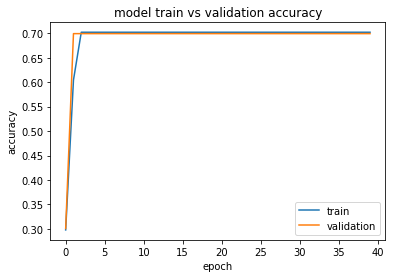

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       223
          1       0.70      1.00      0.82       519

avg / total       0.49      0.70      0.58       742

Accuracy score: 0.699460916442


C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       338
          1       0.77      1.00      0.87      1152

avg / total       0.60      0.77      0.67      1490

Accuracy score: 0.773154362416


In [131]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile0, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile0.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile0)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 1

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/100
2966/2966 [==============================] - 21s 7ms/step - loss: 0.6541 - acc: 0.6780 - val_loss: 0.6243 - val_acc: 0.6995
Epoch 2/100
2966/2966 [==============================] - 5s 2ms/step - loss: 0.6130 - acc: 0.7023 - val_loss: 0.6113 - val_acc: 0.6995
Epoch 3/100
2966/2966 [==============================] - 5s 2ms/step - loss: 0.6091 - acc: 0.7023 - val_loss: 0.6113 - val_acc: 0.6995
Epoch 4/100
2966/2966 [==============================] - 5s 2ms/step - loss: 0.6092 - acc: 0.7023 - val_loss: 0.6113 - val_acc: 0.6995
Epoch 5/100
2966/2966 [==============================] - 5s 2ms/step - loss: 0.6090 - acc: 0.7023 - val_loss: 0.6113 - val_acc: 0.6995
Epoch 6/100
2966/2966 [==============================] - 5s 2ms/step - loss: 0.6091 - acc: 0.7023 - val_loss: 0.6114 - val_acc: 0.6995
Epoch 7/100
2966/2966 [==============================] - 5s 2ms/step - loss: 0.6091 - acc: 0.7023 - val

2966/2966 [==============================] - 6s 2ms/step - loss: 0.6063 - acc: 0.7023 - val_loss: 0.6084 - val_acc: 0.6995
Epoch 61/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.6063 - acc: 0.7023 - val_loss: 0.6082 - val_acc: 0.6995
Epoch 62/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.6060 - acc: 0.7023 - val_loss: 0.6081 - val_acc: 0.6995
Epoch 63/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.6058 - acc: 0.7023 - val_loss: 0.6079 - val_acc: 0.6995
Epoch 64/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.6056 - acc: 0.7023 - val_loss: 0.6078 - val_acc: 0.6995
Epoch 65/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.6057 - acc: 0.7023 - val_loss: 0.6076 - val_acc: 0.6995
Epoch 66/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.6055 - acc: 0.7023 - val_loss: 0.6074 - val_acc: 0.6995
Epoch 67/100
2966/2966 [==============================] - 6s 

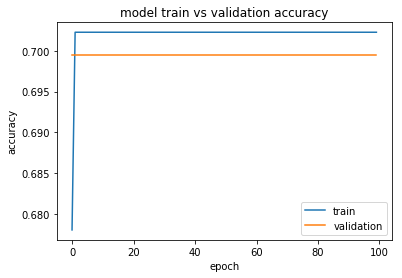

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       223
          1       0.70      1.00      0.82       519

avg / total       0.49      0.70      0.58       742

Accuracy score: 0.699460916442


C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       338
          1       0.77      1.00      0.87      1152

avg / total       0.60      0.77      0.67      1490

Accuracy score: 0.773154362416


In [132]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile1, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile1.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile1)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 2

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/100
2966/2966 [==============================] - 11s 4ms/step - loss: 0.6175 - acc: 0.6935 - val_loss: 0.6114 - val_acc: 0.6995
Epoch 2/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.6105 - acc: 0.7023 - val_loss: 0.6115 - val_acc: 0.6995
Epoch 3/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.6091 - acc: 0.7023 - val_loss: 0.6118 - val_acc: 0.6995
Epoch 4/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.5670 - acc: 0.7114 - val_loss: 0.5604 - val_acc: 0.7143
Epoch 5/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.5522 - acc: 0.7299 - val_loss: 0.5494 - val_acc: 0.7399
Epoch 6/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.5384 - acc: 0.7384 - val_loss: 0.5325 - val_acc: 0.7399
Epoch 7/100
2966/2966 [==============================] - 6s 2ms/step - loss: 0.5377 - acc: 0.7431 - val

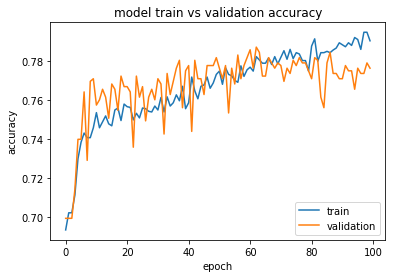

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.71      0.43      0.54       223
          1       0.79      0.92      0.85       519

avg / total       0.77      0.78      0.76       742

Accuracy score: 0.77628032345
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.28      0.42      0.33       338
          1       0.80      0.68      0.73      1152

avg / total       0.68      0.62      0.64      1490

Accuracy score: 0.618120805369


In [70]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile2, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile2.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile2)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 3

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/100
2966/2966 [==============================] - 28s 10ms/step - loss: 0.8097 - acc: 0.2977 - val_loss: 0.7334 - val_acc: 0.3005
Epoch 2/100
2966/2966 [==============================] - 11s 4ms/step - loss: 0.6791 - acc: 0.5634 - val_loss: 0.6355 - val_acc: 0.6995
Epoch 3/100
2966/2966 [==============================] - 10s 4ms/step - loss: 0.6180 - acc: 0.7023 - val_loss: 0.6125 - val_acc: 0.6995
Epoch 4/100
2966/2966 [==============================] - 10s 4ms/step - loss: 0.6093 - acc: 0.7023 - val_loss: 0.6111 - val_acc: 0.6995
Epoch 5/100
2966/2966 [==============================] - 10s 4ms/step - loss: 0.6087 - acc: 0.7023 - val_loss: 0.6110 - val_acc: 0.6995
Epoch 6/100
2966/2966 [==============================] - 10s 4ms/step - loss: 0.6087 - acc: 0.7023 - val_loss: 0.6110 - val_acc: 0.6995
Epoch 7/100
2966/2966 [==============================] - 10s 4ms/step - loss: 0.6087 - acc: 0.702

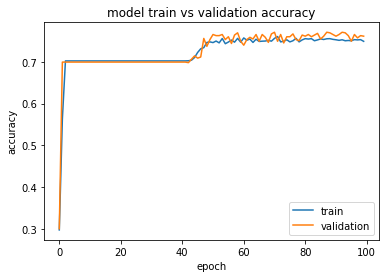

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.34      0.46       223
          1       0.77      0.94      0.85       519

avg / total       0.75      0.76      0.73       742

Accuracy score: 0.761455525606
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.26      0.43      0.32       338
          1       0.79      0.63      0.70      1152

avg / total       0.67      0.59      0.62      1490

Accuracy score: 0.586577181208


In [134]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile3, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile3.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile3)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 4

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/200
2966/2966 [==============================] - 29s 10ms/step - loss: 0.6223 - acc: 0.6834 - val_loss: 0.6112 - val_acc: 0.6995
Epoch 2/200
2966/2966 [==============================] - 12s 4ms/step - loss: 0.6091 - acc: 0.7023 - val_loss: 0.6172 - val_acc: 0.6995
Epoch 3/200
2966/2966 [==============================] - 12s 4ms/step - loss: 0.6098 - acc: 0.7023 - val_loss: 0.6107 - val_acc: 0.6995
Epoch 4/200
2966/2966 [==============================] - 12s 4ms/step - loss: 0.6087 - acc: 0.7023 - val_loss: 0.6105 - val_acc: 0.6995
Epoch 5/200
2966/2966 [==============================] - 12s 4ms/step - loss: 0.6090 - acc: 0.7023 - val_loss: 0.6104 - val_acc: 0.6995
Epoch 6/200
2966/2966 [==============================] - 12s 4ms/step - loss: 0.6085 - acc: 0.7023 - val_loss: 0.6091 - val_acc: 0.6995
Epoch 7/200
2966/2966 [==============================] - 12s 4ms/step - loss: 0.6075 - acc: 0.702

2966/2966 [==============================] - 13s 4ms/step - loss: 0.4656 - acc: 0.7876 - val_loss: 0.4534 - val_acc: 0.7898
Epoch 118/200
2966/2966 [==============================] - 13s 4ms/step - loss: 0.4656 - acc: 0.7886 - val_loss: 0.4526 - val_acc: 0.7965
Epoch 119/200
2966/2966 [==============================] - 13s 4ms/step - loss: 0.4657 - acc: 0.7910 - val_loss: 0.4529 - val_acc: 0.7925
Epoch 120/200
2966/2966 [==============================] - 13s 4ms/step - loss: 0.4658 - acc: 0.7893 - val_loss: 0.4529 - val_acc: 0.7925
Epoch 121/200
2966/2966 [==============================] - 13s 4ms/step - loss: 0.4656 - acc: 0.7879 - val_loss: 0.4528 - val_acc: 0.7925
Epoch 122/200
2966/2966 [==============================] - 13s 4ms/step - loss: 0.4656 - acc: 0.7903 - val_loss: 0.4526 - val_acc: 0.7951
Epoch 123/200
2966/2966 [==============================] - 13s 4ms/step - loss: 0.4654 - acc: 0.7893 - val_loss: 0.4541 - val_acc: 0.7898
Epoch 124/200
2966/2966 [=======================

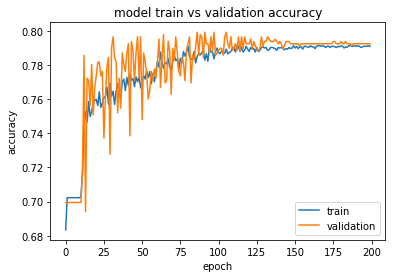

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.74      0.47      0.58       223
          1       0.80      0.93      0.86       519

avg / total       0.79      0.79      0.78       742

Accuracy score: 0.792452830189
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.33      0.52      0.40       338
          1       0.83      0.69      0.75      1152

avg / total       0.72      0.65      0.67      1490

Accuracy score: 0.648993288591


In [135]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile4, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile4.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=RMSprop(lr=0.0005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile4)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 5

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/100
2966/2966 [==============================] - 44s 15ms/step - loss: 0.6199 - acc: 0.6800 - val_loss: 0.6121 - val_acc: 0.6995
Epoch 2/100
2966/2966 [==============================] - 19s 7ms/step - loss: 0.6107 - acc: 0.7023 - val_loss: 0.6125 - val_acc: 0.6995
Epoch 3/100
2966/2966 [==============================] - 19s 7ms/step - loss: 0.6096 - acc: 0.7023 - val_loss: 0.6111 - val_acc: 0.6995
Epoch 4/100
2966/2966 [==============================] - 18s 6ms/step - loss: 0.6090 - acc: 0.7023 - val_loss: 0.6086 - val_acc: 0.6995
Epoch 5/100
2966/2966 [==============================] - 19s 6ms/step - loss: 0.6043 - acc: 0.7023 - val_loss: 0.5995 - val_acc: 0.6995
Epoch 6/100
2966/2966 [==============================] - 20s 7ms/step - loss: 0.5848 - acc: 0.7023 - val_loss: 0.5917 - val_acc: 0.6995
Epoch 7/100
2966/2966 [==============================] - 18s 6ms/step - loss: 0.5534 - acc: 0.715

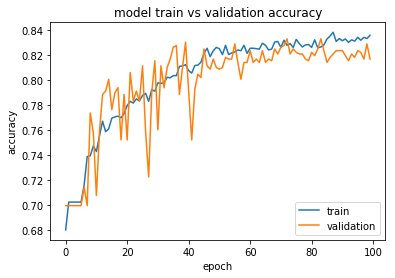

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.83      0.49      0.62       223
          1       0.81      0.96      0.88       519

avg / total       0.82      0.82      0.80       742

Accuracy score: 0.816711590296
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.46      0.52      0.49       338
          1       0.85      0.82      0.84      1152

avg / total       0.76      0.75      0.76      1490

Accuracy score: 0.751677852349


In [154]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile5, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile5.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile5)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 6

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/70
2966/2966 [==============================] - 68s 23ms/step - loss: 0.6252 - acc: 0.6733 - val_loss: 0.6112 - val_acc: 0.6995
Epoch 2/70
2966/2966 [==============================] - 23s 8ms/step - loss: 0.6101 - acc: 0.7023 - val_loss: 0.6113 - val_acc: 0.6995
Epoch 3/70
2966/2966 [==============================] - 23s 8ms/step - loss: 0.6095 - acc: 0.7023 - val_loss: 0.6106 - val_acc: 0.6995
Epoch 4/70
2966/2966 [==============================] - 22s 7ms/step - loss: 0.6087 - acc: 0.7023 - val_loss: 0.6100 - val_acc: 0.6995
Epoch 5/70
2966/2966 [==============================] - 22s 8ms/step - loss: 0.6079 - acc: 0.7023 - val_loss: 0.6063 - val_acc: 0.6995
Epoch 6/70
2966/2966 [==============================] - 22s 7ms/step - loss: 0.5932 - acc: 0.7023 - val_loss: 0.5698 - val_acc: 0.6995
Epoch 7/70
2966/2966 [==============================] - 22s 8ms/step - loss: 0.5212 - acc: 0.7336 - val

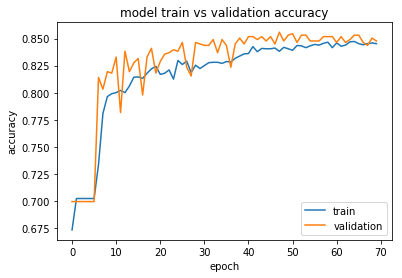

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.89      0.57      0.69       223
          1       0.84      0.97      0.90       519

avg / total       0.85      0.85      0.84       742

Accuracy score: 0.847708894879
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.78      0.44      0.56       338
          1       0.85      0.96      0.91      1152

avg / total       0.84      0.84      0.83      1490

Accuracy score: 0.844966442953


In [157]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile6, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile6.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile6)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 7

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/100
2966/2966 [==============================] - 69s 23ms/step - loss: 0.6116 - acc: 0.7023 - val_loss: 0.6135 - val_acc: 0.6995
Epoch 2/100
2966/2966 [==============================] - 26s 9ms/step - loss: 0.6104 - acc: 0.7023 - val_loss: 0.6116 - val_acc: 0.6995
Epoch 3/100
2966/2966 [==============================] - 27s 9ms/step - loss: 0.6102 - acc: 0.7023 - val_loss: 0.6113 - val_acc: 0.6995
Epoch 4/100
2966/2966 [==============================] - 24s 8ms/step - loss: 0.6092 - acc: 0.7023 - val_loss: 0.6109 - val_acc: 0.6995
Epoch 5/100
2966/2966 [==============================] - 24s 8ms/step - loss: 0.6100 - acc: 0.7023 - val_loss: 0.6102 - val_acc: 0.6995
Epoch 6/100
2966/2966 [==============================] - 25s 9ms/step - loss: 0.5985 - acc: 0.7023 - val_loss: 0.5535 - val_acc: 0.6995
Epoch 7/100
2966/2966 [==============================] - 28s 9ms/step - loss: 0.5119 - acc: 0.747

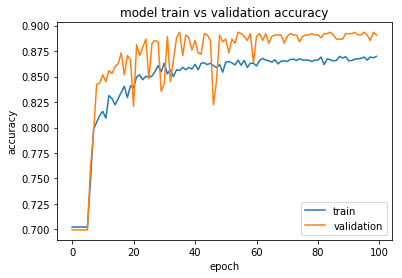

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.93      0.69      0.79       223
          1       0.88      0.98      0.93       519

avg / total       0.89      0.89      0.89       742

Accuracy score: 0.890835579515
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.69      0.67      0.68       338
          1       0.90      0.91      0.91      1152

avg / total       0.86      0.86      0.86      1490

Accuracy score: 0.858389261745


In [161]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile7, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile7.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile7)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 8

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/100
2966/2966 [==============================] - 40s 14ms/step - loss: 0.6137 - acc: 0.7023 - val_loss: 0.6183 - val_acc: 0.6995
Epoch 2/100
2966/2966 [==============================] - 22s 7ms/step - loss: 0.6108 - acc: 0.7023 - val_loss: 0.6115 - val_acc: 0.6995
Epoch 3/100
2966/2966 [==============================] - 22s 7ms/step - loss: 0.6093 - acc: 0.7023 - val_loss: 0.6114 - val_acc: 0.6995
Epoch 4/100
2966/2966 [==============================] - 22s 7ms/step - loss: 0.6099 - acc: 0.7023 - val_loss: 0.6128 - val_acc: 0.6995
Epoch 5/100
2966/2966 [==============================] - 22s 7ms/step - loss: 0.6059 - acc: 0.7023 - val_loss: 0.5919 - val_acc: 0.6995
Epoch 6/100
2966/2966 [==============================] - 22s 7ms/step - loss: 0.5496 - acc: 0.7242 - val_loss: 0.5787 - val_acc: 0.6226
Epoch 7/100
2966/2966 [==============================] - 22s 7ms/step - loss: 0.4496 - acc: 0.793

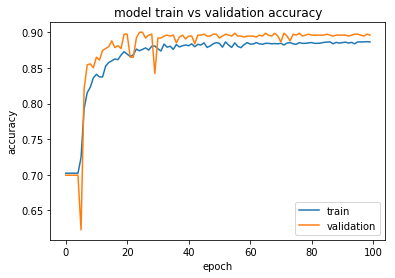

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.73      0.81       223
          1       0.89      0.97      0.93       519

avg / total       0.90      0.90      0.89       742

Accuracy score: 0.896226415094
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.66      0.77       338
          1       0.91      0.98      0.94      1152

avg / total       0.91      0.91      0.90      1490

Accuracy score: 0.909395973154


In [139]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile8, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile8.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile8)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 9

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/100
2966/2966 [==============================] - 27s 9ms/step - loss: 0.6926 - acc: 0.5600 - val_loss: 0.6114 - val_acc: 0.6995
Epoch 2/100
2966/2966 [==============================] - 23s 8ms/step - loss: 0.6094 - acc: 0.7023 - val_loss: 0.6110 - val_acc: 0.6995
Epoch 3/100
2966/2966 [==============================] - 23s 8ms/step - loss: 0.6091 - acc: 0.7023 - val_loss: 0.6108 - val_acc: 0.6995
Epoch 4/100
2966/2966 [==============================] - 23s 8ms/step - loss: 0.6089 - acc: 0.7023 - val_loss: 0.6104 - val_acc: 0.6995
Epoch 5/100
2966/2966 [==============================] - 22s 7ms/step - loss: 0.6083 - acc: 0.7023 - val_loss: 0.6100 - val_acc: 0.6995
Epoch 6/100
2966/2966 [==============================] - 21s 7ms/step - loss: 0.6075 - acc: 0.7023 - val_loss: 0.6069 - val_acc: 0.6995
Epoch 7/100
2966/2966 [==============================] - 21s 7ms/step - loss: 0.5995 - acc: 0.7023

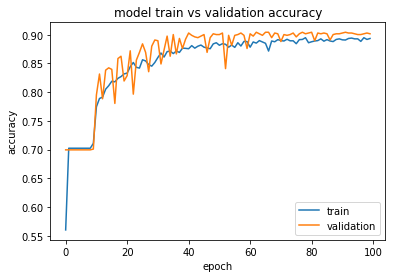

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.94      0.72      0.81       223
          1       0.89      0.98      0.93       519

avg / total       0.91      0.90      0.90       742

Accuracy score: 0.901617250674
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.83      0.76      0.79       338
          1       0.93      0.95      0.94      1152

avg / total       0.91      0.91      0.91      1490

Accuracy score: 0.909395973154


In [59]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_Decile9, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(BBB_Train_Decile9.shape[1],3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.0000025, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_Decile9)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



### BBB Decile 10 (full dataset)

Fit LSTM Course BBB - 2 Target Classes
Train on 2966 samples, validate on 742 samples
Epoch 1/70
2966/2966 [==============================] - 27s 9ms/step - loss: 0.6101 - acc: 0.7023 - val_loss: 0.6160 - val_acc: 0.6995
Epoch 2/70
2966/2966 [==============================] - 24s 8ms/step - loss: 0.6100 - acc: 0.7023 - val_loss: 0.6115 - val_acc: 0.6995
Epoch 3/70
2966/2966 [==============================] - 25s 8ms/step - loss: 0.6098 - acc: 0.7023 - val_loss: 0.6116 - val_acc: 0.6995
Epoch 4/70
2966/2966 [==============================] - 24s 8ms/step - loss: 0.6094 - acc: 0.7023 - val_loss: 0.6130 - val_acc: 0.6995
Epoch 5/70
2966/2966 [==============================] - 22s 7ms/step - loss: 0.6096 - acc: 0.7023 - val_loss: 0.6107 - val_acc: 0.6995
Epoch 6/70
2966/2966 [==============================] - 22s 7ms/step - loss: 0.6049 - acc: 0.7023 - val_loss: 0.6116 - val_acc: 0.6995
Epoch 7/70
2966/2966 [==============================] - 22s 8ms/step - loss: 0.5851 - acc: 0.7023 - val_

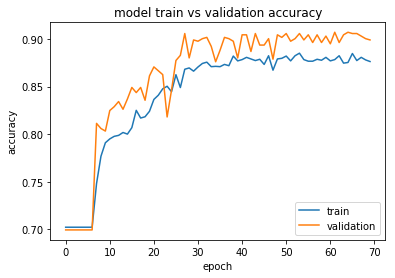

-------------------------------------------
Validate LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.98      0.68      0.80       223
          1       0.88      0.99      0.93       519

avg / total       0.91      0.90      0.89       742

Accuracy score: 0.898921832884
-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.71      0.80       338
          1       0.92      0.98      0.95      1152

avg / total       0.92      0.92      0.91      1490

Accuracy score: 0.91677852349


In [56]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(BBB_Train_3D, BBB_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')


BBB_model = Sequential()
BBB_model.add(Masking(mask_value=-1, input_shape =(293,3) ))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
BBB_model.add(LSTM(32, activation='sigmoid'))
BBB_model.add(Dense(1, activation='sigmoid'))

BBB_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_BBB_val = BBB_model.predict(X_val)
y_classes_BBB_val = np.round(y_pred_BBB_val)
    
print('-------------------------------------------')
print('Validate LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB_val, y_true=y_val)))


# Test model
y_pred_BBB = BBB_model.predict(BBB_Test_3D)
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))



# DDD LSTMs for every timestep

### DDD Pre-course (Decile 0)

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/200
2149/2149 [==============================] - 18s 8ms/step - loss: 0.6331 - acc: 0.6659 - val_loss: 0.6590 - val_acc: 0.6413
Epoch 2/200
2149/2149 [==============================] - 2s 979us/step - loss: 0.6236 - acc: 0.6854 - val_loss: 0.6559 - val_acc: 0.6413
Epoch 3/200
2149/2149 [==============================] - 2s 974us/step - loss: 0.6237 - acc: 0.6854 - val_loss: 0.6598 - val_acc: 0.6413
Epoch 4/200
2149/2149 [==============================] - 2s 967us/step - loss: 0.6240 - acc: 0.6854 - val_loss: 0.6550 - val_acc: 0.6413
Epoch 5/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.6248 - acc: 0.6854 - val_loss: 0.6609 - val_acc: 0.6413
Epoch 6/200
2149/2149 [==============================] - 2s 966us/step - loss: 0.6240 - acc: 0.6854 - val_loss: 0.6540 - val_acc: 0.6413
Epoch 7/200
2149/2149 [==============================] - 2s 957us/step - loss: 0.6240 - acc: 0.

Epoch 59/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5927 - acc: 0.6906 - val_loss: 0.6300 - val_acc: 0.6450
Epoch 60/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5935 - acc: 0.6887 - val_loss: 0.6267 - val_acc: 0.6487
Epoch 61/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5933 - acc: 0.6915 - val_loss: 0.6289 - val_acc: 0.6468
Epoch 62/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5927 - acc: 0.6887 - val_loss: 0.6280 - val_acc: 0.6487
Epoch 63/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5922 - acc: 0.6896 - val_loss: 0.6312 - val_acc: 0.6450
Epoch 64/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5916 - acc: 0.6906 - val_loss: 0.6264 - val_acc: 0.6487
Epoch 65/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5931 - acc: 0.6901 - val_loss: 0.6266 - val_acc: 0.6487
Epoch 66/200
2149/2149 [========================

2149/2149 [==============================] - 2s 1ms/step - loss: 0.5912 - acc: 0.6910 - val_loss: 0.6277 - val_acc: 0.6487
Epoch 175/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5912 - acc: 0.6910 - val_loss: 0.6277 - val_acc: 0.6487
Epoch 176/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5912 - acc: 0.6910 - val_loss: 0.6277 - val_acc: 0.6487
Epoch 177/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5912 - acc: 0.6910 - val_loss: 0.6277 - val_acc: 0.6487
Epoch 178/200
2149/2149 [==============================] - 3s 1ms/step - loss: 0.5912 - acc: 0.6910 - val_loss: 0.6277 - val_acc: 0.6487
Epoch 179/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5912 - acc: 0.6910 - val_loss: 0.6277 - val_acc: 0.6487
Epoch 180/200
2149/2149 [==============================] - 2s 1ms/step - loss: 0.5912 - acc: 0.6910 - val_loss: 0.6277 - val_acc: 0.6487
Epoch 181/200
2149/2149 [==============================

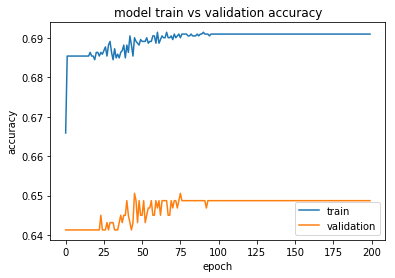

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.83      0.03      0.05       193
          1       0.65      1.00      0.78       345

avg / total       0.71      0.65      0.52       538

Accuracy score: 0.648698884758
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.71      0.08      0.14       329
          1       0.72      0.99      0.83       792

avg / total       0.72      0.72      0.63      1121

Accuracy score: 0.719892952721


In [130]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile0, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile0.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile0)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 1

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 19s 9ms/step - loss: 0.6276 - acc: 0.6854 - val_loss: 0.6581 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6241 - acc: 0.6854 - val_loss: 0.6598 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 4s 2ms/step - loss: 0.6077 - acc: 0.6896 - val_loss: 0.6374 - val_acc: 0.6413
Epoch 4/100
2149/2149 [==============================] - 4s 2ms/step - loss: 0.5538 - acc: 0.7213 - val_loss: 0.5720 - val_acc: 0.6970
Epoch 5/100
2149/2149 [==============================] - 4s 2ms/step - loss: 0.5349 - acc: 0.7334 - val_loss: 0.5403 - val_acc: 0.7100
Epoch 6/100
2149/2149 [==============================] - 4s 2ms/step - loss: 0.5289 - acc: 0.7385 - val_loss: 0.5537 - val_acc: 0.7045
Epoch 7/100
2149/2149 [==============================] - 4s 2ms/step - loss: 0.5308 - acc: 0.7422 - val

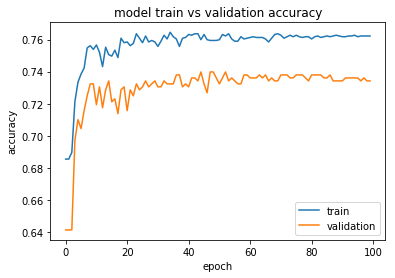

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.67      0.50      0.58       193
          1       0.76      0.86      0.81       345

avg / total       0.73      0.73      0.72       538

Accuracy score: 0.734200743494
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.60      0.42      0.49       329
          1       0.78      0.89      0.83       792

avg / total       0.73      0.75      0.73      1121

Accuracy score: 0.747546833185


In [129]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile1, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile1.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile1)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 2

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 21s 10ms/step - loss: 0.6282 - acc: 0.6854 - val_loss: 0.6550 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 5s 3ms/step - loss: 0.6246 - acc: 0.6854 - val_loss: 0.6606 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 5s 3ms/step - loss: 0.6221 - acc: 0.6854 - val_loss: 0.6166 - val_acc: 0.6413
Epoch 4/100
2149/2149 [==============================] - 5s 3ms/step - loss: 0.5573 - acc: 0.7166 - val_loss: 0.6052 - val_acc: 0.6859
Epoch 5/100
2149/2149 [==============================] - 5s 3ms/step - loss: 0.5268 - acc: 0.7497 - val_loss: 0.5982 - val_acc: 0.7230
Epoch 6/100
2149/2149 [==============================] - 5s 3ms/step - loss: 0.5176 - acc: 0.7585 - val_loss: 0.5329 - val_acc: 0.7398
Epoch 7/100
2149/2149 [==============================] - 5s 3ms/step - loss: 0.5124 - acc: 0.7566 - va

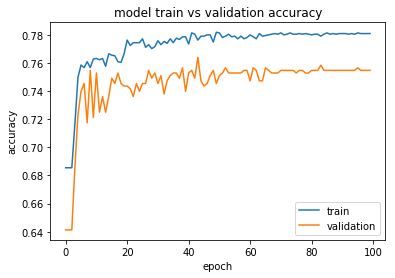

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.52      0.60       193
          1       0.77      0.88      0.82       345

avg / total       0.75      0.75      0.74       538

Accuracy score: 0.754646840149
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.54      0.68      0.60       329
          1       0.85      0.76      0.80       792

avg / total       0.76      0.74      0.74      1121

Accuracy score: 0.735057983943


In [128]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile2, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile2.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile2)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 3

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 22s 10ms/step - loss: 0.6383 - acc: 0.6687 - val_loss: 0.6582 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 7s 3ms/step - loss: 0.6240 - acc: 0.6854 - val_loss: 0.6526 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 7s 3ms/step - loss: 0.6235 - acc: 0.6854 - val_loss: 0.6540 - val_acc: 0.6413
Epoch 4/100
2149/2149 [==============================] - 7s 3ms/step - loss: 0.5822 - acc: 0.7045 - val_loss: 0.5635 - val_acc: 0.7305
Epoch 5/100
2149/2149 [==============================] - 7s 3ms/step - loss: 0.5032 - acc: 0.7729 - val_loss: 0.5469 - val_acc: 0.7305
Epoch 6/100
2149/2149 [==============================] - 7s 3ms/step - loss: 0.4950 - acc: 0.7748 - val_loss: 0.5015 - val_acc: 0.7602
Epoch 7/100
2149/2149 [==============================] - 7s 3ms/step - loss: 0.5161 - acc: 0.7631 - va

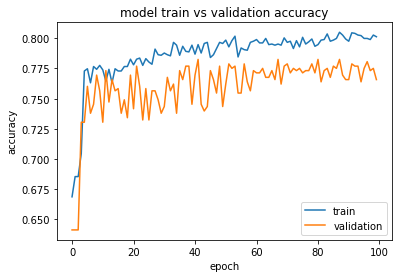

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.75      0.52      0.62       193
          1       0.77      0.90      0.83       345

avg / total       0.76      0.77      0.75       538

Accuracy score: 0.765799256506
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.67      0.57      0.62       329
          1       0.83      0.88      0.86       792

avg / total       0.79      0.79      0.79      1121

Accuracy score: 0.792149866191


In [127]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile3, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile3.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile3)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 4

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 24s 11ms/step - loss: 0.6257 - acc: 0.6854 - val_loss: 0.6610 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.6225 - acc: 0.6854 - val_loss: 0.6476 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.5286 - acc: 0.7422 - val_loss: 0.5136 - val_acc: 0.7602
Epoch 4/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4744 - acc: 0.7869 - val_loss: 0.4888 - val_acc: 0.7584
Epoch 5/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4773 - acc: 0.7748 - val_loss: 0.4670 - val_acc: 0.7770
Epoch 6/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4646 - acc: 0.7864 - val_loss: 0.4575 - val_acc: 0.7714
Epoch 7/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4710 - acc: 0.7794 - va

Epoch 59/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4450 - acc: 0.7878 - val_loss: 0.4519 - val_acc: 0.7807
Epoch 60/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4472 - acc: 0.7846 - val_loss: 0.4535 - val_acc: 0.7825

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 61/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4431 - acc: 0.7887 - val_loss: 0.4559 - val_acc: 0.7825
Epoch 62/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4423 - acc: 0.7897 - val_loss: 0.4619 - val_acc: 0.7714
Epoch 63/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4450 - acc: 0.7901 - val_loss: 0.4556 - val_acc: 0.7807
Epoch 64/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4429 - acc: 0.7873 - val_loss: 0.4507 - val_acc: 0.7788
Epoch 65/100
2149/2149 [==============================] - 9s 4ms/step - loss: 0.4427 - acc: 0.7873 - va

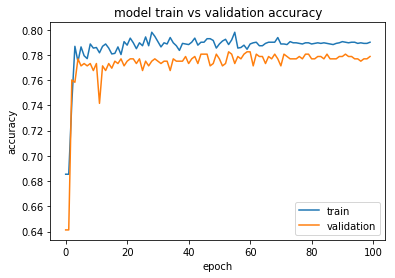

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.79      0.52      0.63       193
          1       0.78      0.92      0.84       345

avg / total       0.78      0.78      0.77       538

Accuracy score: 0.778810408922
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.50      0.59       329
          1       0.81      0.92      0.86       792

avg / total       0.79      0.79      0.78      1121

Accuracy score: 0.794826048171


In [126]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile4, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile4.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile4)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 5

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 25s 12ms/step - loss: 0.6396 - acc: 0.6631 - val_loss: 0.6558 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 10s 5ms/step - loss: 0.6224 - acc: 0.6854 - val_loss: 0.6505 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 10s 5ms/step - loss: 0.5709 - acc: 0.7064 - val_loss: 0.4791 - val_acc: 0.7955
Epoch 4/100
2149/2149 [==============================] - 10s 5ms/step - loss: 0.4745 - acc: 0.7939 - val_loss: 0.4568 - val_acc: 0.8011
Epoch 5/100
2149/2149 [==============================] - 10s 5ms/step - loss: 0.4511 - acc: 0.7980 - val_loss: 0.4628 - val_acc: 0.7918
Epoch 6/100
2149/2149 [==============================] - 10s 5ms/step - loss: 0.4328 - acc: 0.8032 - val_loss: 0.4308 - val_acc: 0.8030
Epoch 7/100
2149/2149 [==============================] - 10s 5ms/step - loss: 0.4415 - acc: 0.804

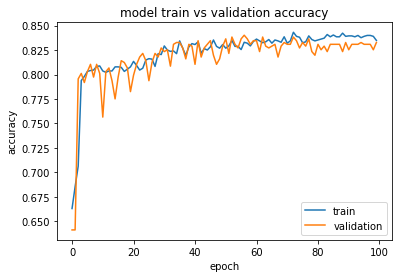

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.60      0.72       193
          1       0.81      0.97      0.88       345

avg / total       0.84      0.83      0.82       538

Accuracy score: 0.832713754647
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.62      0.67       329
          1       0.85      0.90      0.87       792

avg / total       0.81      0.82      0.81      1121

Accuracy score: 0.817127564674


In [125]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile5, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile5.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile5)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 6

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 26s 12ms/step - loss: 0.6279 - acc: 0.6854 - val_loss: 0.6526 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 12s 5ms/step - loss: 0.6197 - acc: 0.6854 - val_loss: 0.6119 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 12s 5ms/step - loss: 0.6226 - acc: 0.6854 - val_loss: 0.6480 - val_acc: 0.6413
Epoch 4/100
2149/2149 [==============================] - 12s 5ms/step - loss: 0.6113 - acc: 0.6650 - val_loss: 0.6508 - val_acc: 0.6413
Epoch 5/100
2149/2149 [==============================] - 12s 5ms/step - loss: 0.5431 - acc: 0.7194 - val_loss: 0.4405 - val_acc: 0.8104
Epoch 6/100
2149/2149 [==============================] - 12s 5ms/step - loss: 0.4358 - acc: 0.8041 - val_loss: 0.4188 - val_acc: 0.8253
Epoch 7/100
2149/2149 [==============================] - 12s 5ms/step - loss: 0.4375 - acc: 0.805

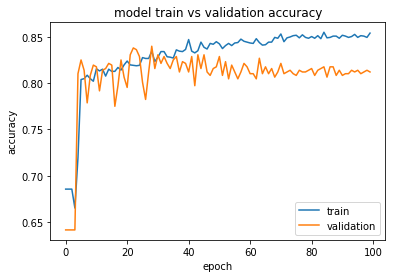

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.83      0.60      0.70       193
          1       0.81      0.93      0.86       345

avg / total       0.81      0.81      0.80       538

Accuracy score: 0.812267657993
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.80      0.54      0.64       329
          1       0.83      0.94      0.88       792

avg / total       0.82      0.82      0.81      1121

Accuracy score: 0.824264049955


In [124]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile6, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile6.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile6)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 7

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 28s 13ms/step - loss: 0.6277 - acc: 0.6799 - val_loss: 0.6528 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 14s 6ms/step - loss: 0.6245 - acc: 0.6854 - val_loss: 0.6490 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 14s 6ms/step - loss: 0.5634 - acc: 0.7134 - val_loss: 0.5056 - val_acc: 0.7621
Epoch 4/100
2149/2149 [==============================] - 13s 6ms/step - loss: 0.4801 - acc: 0.7766 - val_loss: 0.4796 - val_acc: 0.7937
Epoch 5/100
2149/2149 [==============================] - 14s 6ms/step - loss: 0.4325 - acc: 0.8036 - val_loss: 0.4003 - val_acc: 0.8197
Epoch 6/100
2149/2149 [==============================] - 14s 6ms/step - loss: 0.4121 - acc: 0.8143 - val_loss: 0.4220 - val_acc: 0.7974
Epoch 7/100
2149/2149 [==============================] - 14s 6ms/step - loss: 0.4015 - acc: 0.810

2149/2149 [==============================] - 14s 6ms/step - loss: 0.3172 - acc: 0.8525 - val_loss: 0.3506 - val_acc: 0.8234
Epoch 60/100
2149/2149 [==============================] - 14s 6ms/step - loss: 0.3175 - acc: 0.8539 - val_loss: 0.3471 - val_acc: 0.8290
Epoch 61/100
2149/2149 [==============================] - 14s 6ms/step - loss: 0.3219 - acc: 0.8534 - val_loss: 0.3353 - val_acc: 0.8401
Epoch 62/100
2149/2149 [==============================] - 13s 6ms/step - loss: 0.3215 - acc: 0.8557 - val_loss: 0.3413 - val_acc: 0.8290
Epoch 63/100
2149/2149 [==============================] - 13s 6ms/step - loss: 0.3176 - acc: 0.8525 - val_loss: 0.3502 - val_acc: 0.8253
Epoch 64/100
2149/2149 [==============================] - 13s 6ms/step - loss: 0.3179 - acc: 0.8548 - val_loss: 0.3342 - val_acc: 0.8420
Epoch 65/100
2149/2149 [==============================] - 13s 6ms/step - loss: 0.3178 - acc: 0.8520 - val_loss: 0.3491 - val_acc: 0.8234
Epoch 66/100
2149/2149 [==============================

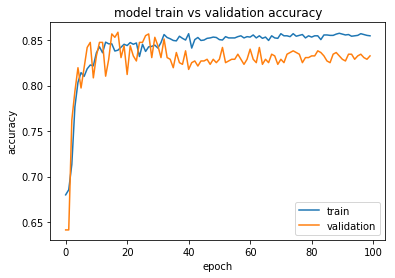

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.96      0.56      0.71       193
          1       0.80      0.99      0.88       345

avg / total       0.86      0.83      0.82       538

Accuracy score: 0.832713754647
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.80      0.58      0.67       329
          1       0.84      0.94      0.89       792

avg / total       0.83      0.83      0.83      1121

Accuracy score: 0.834076717217


In [123]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile7, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile7.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile7)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 8

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 29s 14ms/step - loss: 0.6263 - acc: 0.6789 - val_loss: 0.6520 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 15s 7ms/step - loss: 0.6139 - acc: 0.6873 - val_loss: 0.6242 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 15s 7ms/step - loss: 0.4763 - acc: 0.7711 - val_loss: 0.5372 - val_acc: 0.7937
Epoch 4/100
2149/2149 [==============================] - 15s 7ms/step - loss: 0.4322 - acc: 0.8050 - val_loss: 0.4910 - val_acc: 0.7695
Epoch 5/100
2149/2149 [==============================] - 15s 7ms/step - loss: 0.3917 - acc: 0.8246 - val_loss: 0.4452 - val_acc: 0.8011
Epoch 6/100
2149/2149 [==============================] - 15s 7ms/step - loss: 0.3809 - acc: 0.8311 - val_loss: 0.4678 - val_acc: 0.7974
Epoch 7/100
2149/2149 [==============================] - 15s 7ms/step - loss: 0.3754 - acc: 0.826

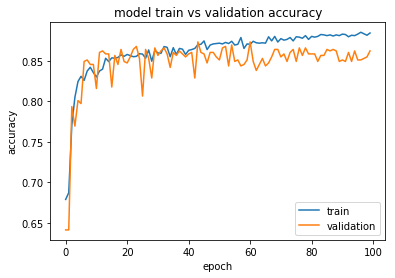

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.68      0.78       193
          1       0.84      0.97      0.90       345

avg / total       0.87      0.86      0.86       538

Accuracy score: 0.862453531599
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.81      0.59      0.68       329
          1       0.85      0.94      0.89       792

avg / total       0.84      0.84      0.83      1121

Accuracy score: 0.839429081178


In [122]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile8, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile8.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile8)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 9

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 44s 20ms/step - loss: 0.6273 - acc: 0.6817 - val_loss: 0.6556 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 21s 10ms/step - loss: 0.6252 - acc: 0.6854 - val_loss: 0.6535 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 20s 10ms/step - loss: 0.6123 - acc: 0.6854 - val_loss: 0.6818 - val_acc: 0.6413
Epoch 4/100
2149/2149 [==============================] - 21s 10ms/step - loss: 0.6231 - acc: 0.6854 - val_loss: 0.6640 - val_acc: 0.6413
Epoch 5/100
2149/2149 [==============================] - 21s 10ms/step - loss: 0.6253 - acc: 0.6854 - val_loss: 0.6599 - val_acc: 0.6413
Epoch 6/100
2149/2149 [==============================] - 21s 10ms/step - loss: 0.6238 - acc: 0.6854 - val_loss: 0.6593 - val_acc: 0.6413
Epoch 7/100
2149/2149 [==============================] - 21s 10ms/step - loss: 0.6242 - acc:

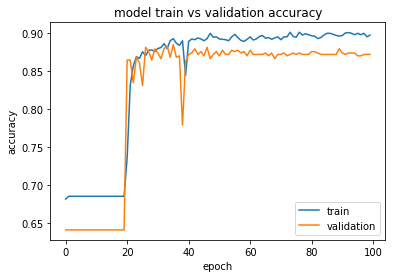

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.70      0.80       193
          1       0.85      0.97      0.91       345

avg / total       0.88      0.87      0.87       538

Accuracy score: 0.871747211896
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.76      0.72      0.74       329
          1       0.89      0.91      0.90       792

avg / total       0.85      0.85      0.85      1121

Accuracy score: 0.851917930419


In [155]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_Decile9, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(DDD_Train_Decile9.shape[1],3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_Decile9)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

### DDD Decile 10

Fit LSTM Course DDD - 2 Target Classes
Train on 2149 samples, validate on 538 samples
Epoch 1/100
2149/2149 [==============================] - 29s 14ms/step - loss: 0.6270 - acc: 0.6854 - val_loss: 0.6545 - val_acc: 0.6413
Epoch 2/100
2149/2149 [==============================] - 18s 8ms/step - loss: 0.6244 - acc: 0.6854 - val_loss: 0.6664 - val_acc: 0.6413
Epoch 3/100
2149/2149 [==============================] - 18s 8ms/step - loss: 0.5480 - acc: 0.7292 - val_loss: 0.4193 - val_acc: 0.8364
Epoch 4/100
2149/2149 [==============================] - 18s 8ms/step - loss: 0.4018 - acc: 0.8181 - val_loss: 0.3845 - val_acc: 0.8364
Epoch 5/100
2149/2149 [==============================] - 18s 8ms/step - loss: 0.3439 - acc: 0.8571 - val_loss: 0.3499 - val_acc: 0.8680
Epoch 6/100
2149/2149 [==============================] - 19s 9ms/step - loss: 0.3006 - acc: 0.8734 - val_loss: 0.3331 - val_acc: 0.8699
Epoch 7/100
2149/2149 [==============================] - 19s 9ms/step - loss: 0.2772 - acc: 0.886

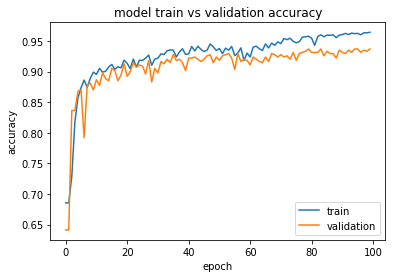

-------------------------------------------
Validate LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.94      0.88      0.91       193
          1       0.93      0.97      0.95       345

avg / total       0.94      0.94      0.94       538

Accuracy score: 0.936802973978
-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.95      0.77      0.85       329
          1       0.91      0.98      0.95       792

avg / total       0.92      0.92      0.92      1121

Accuracy score: 0.922390722569


In [108]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(DDD_Train_3D, DDD_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

DDD_model = Sequential()
DDD_model.add(Masking(mask_value=-1, input_shape =(293,3) ))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
DDD_model.add(LSTM(32, activation='sigmoid'))
DDD_model.add(Dense(1, activation='sigmoid'))

DDD_model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_DDD_val = DDD_model.predict(X_val)
y_classes_DDD_val = np.round(y_pred_DDD_val)
    
print('-------------------------------------------')
print('Validate LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD_val, y_true=y_val)))


# Test model
y_pred_DDD = DDD_model.predict(DDD_Test_3D)
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))

# FFF LSTMs for every timestep

### FFF Pre-course (Decile 0)

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 25s 8ms/step - loss: 0.6319 - acc: 0.6789 - val_loss: 0.6246 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.6206 - acc: 0.6905 - val_loss: 0.6153 - val_acc: 0.6967
Epoch 3/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.6194 - acc: 0.6905 - val_loss: 0.6133 - val_acc: 0.6967
Epoch 4/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.6210 - acc: 0.6905 - val_loss: 0.6131 - val_acc: 0.6967
Epoch 5/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.6169 - acc: 0.6905 - val_loss: 0.5987 - val_acc: 0.6967
Epoch 6/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.6057 - acc: 0.6905 - val_loss: 0.6070 - val_acc: 0.6967
Epoch 7/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.5964 - acc: 0.6905 - val

Epoch 59/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.5804 - acc: 0.6946 - val_loss: 0.5893 - val_acc: 0.6954

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 60/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.5796 - acc: 0.6953 - val_loss: 0.5898 - val_acc: 0.6954
Epoch 61/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.5799 - acc: 0.6953 - val_loss: 0.5901 - val_acc: 0.6954
Epoch 62/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.5797 - acc: 0.6953 - val_loss: 0.5904 - val_acc: 0.6954
Epoch 63/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.5796 - acc: 0.6953 - val_loss: 0.5908 - val_acc: 0.6926
Epoch 64/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.5797 - acc: 0.6912 - val_loss: 0.5901 - val_acc: 0.6954
Epoch 65/100
2927/2927 [==============================] - 3s 1ms/step - loss: 0.5794 - acc: 0.6953 - va

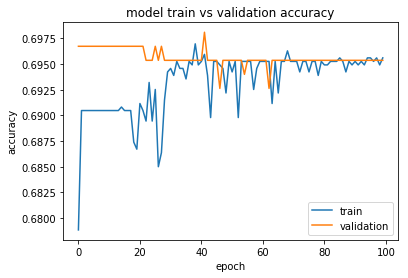

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.44      0.02      0.03       222
          1       0.70      0.99      0.82       510

avg / total       0.62      0.70      0.58       732

Accuracy score: 0.695355191257
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.63      0.09      0.16       349
          1       0.78      0.98      0.87      1117

avg / total       0.74      0.77      0.70      1466

Accuracy score: 0.770804911323


In [141]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile0, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile0.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile0)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 1

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 26s 9ms/step - loss: 0.6243 - acc: 0.6905 - val_loss: 0.6131 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 6s 2ms/step - loss: 0.6162 - acc: 0.6905 - val_loss: 0.5833 - val_acc: 0.6967
Epoch 3/100
2927/2927 [==============================] - 6s 2ms/step - loss: 0.5753 - acc: 0.7082 - val_loss: 0.5334 - val_acc: 0.7281
Epoch 4/100
2927/2927 [==============================] - 6s 2ms/step - loss: 0.5613 - acc: 0.7144 - val_loss: 0.5345 - val_acc: 0.7186
Epoch 5/100
2927/2927 [==============================] - 6s 2ms/step - loss: 0.5572 - acc: 0.7185 - val_loss: 0.5251 - val_acc: 0.7486
Epoch 6/100
2927/2927 [==============================] - 6s 2ms/step - loss: 0.5503 - acc: 0.7304 - val_loss: 0.5362 - val_acc: 0.7514
Epoch 7/100
2927/2927 [==============================] - 5s 2ms/step - loss: 0.5536 - acc: 0.7147 - val

Epoch 59/100
2927/2927 [==============================] - 6s 2ms/step - loss: 0.5148 - acc: 0.7533 - val_loss: 0.5260 - val_acc: 0.7486
Epoch 60/100
2927/2927 [==============================] - 5s 2ms/step - loss: 0.5134 - acc: 0.7482 - val_loss: 0.5257 - val_acc: 0.7459
Epoch 61/100
2927/2927 [==============================] - 5s 2ms/step - loss: 0.5125 - acc: 0.7520 - val_loss: 0.5286 - val_acc: 0.7322
Epoch 62/100
2927/2927 [==============================] - 5s 2ms/step - loss: 0.5124 - acc: 0.7526 - val_loss: 0.5278 - val_acc: 0.7391
Epoch 63/100
2927/2927 [==============================] - 5s 2ms/step - loss: 0.5111 - acc: 0.7526 - val_loss: 0.5272 - val_acc: 0.7473
Epoch 64/100
2927/2927 [==============================] - 5s 2ms/step - loss: 0.5106 - acc: 0.7530 - val_loss: 0.5262 - val_acc: 0.7500
Epoch 65/100
2927/2927 [==============================] - 5s 2ms/step - loss: 0.5098 - acc: 0.7530 - val_loss: 0.5280 - val_acc: 0.7500

Epoch 00065: ReduceLROnPlateau reducing learnin

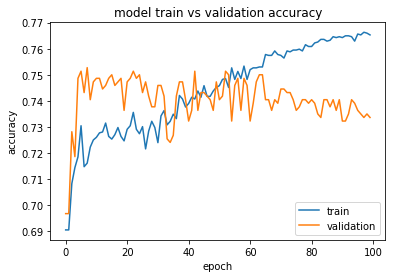

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.60      0.37      0.46       222
          1       0.76      0.89      0.82       510

avg / total       0.71      0.73      0.71       732

Accuracy score: 0.733606557377
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.48      0.46      0.47       349
          1       0.83      0.84      0.84      1117

avg / total       0.75      0.75      0.75      1466

Accuracy score: 0.7517053206


In [142]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile1, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile1.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile1)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 2

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 27s 9ms/step - loss: 0.6256 - acc: 0.6891 - val_loss: 0.6144 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 8s 3ms/step - loss: 0.6194 - acc: 0.6905 - val_loss: 0.6188 - val_acc: 0.6967
Epoch 3/100
2927/2927 [==============================] - 8s 3ms/step - loss: 0.5552 - acc: 0.7216 - val_loss: 0.4882 - val_acc: 0.7787
Epoch 4/100
2927/2927 [==============================] - 8s 3ms/step - loss: 0.5157 - acc: 0.7496 - val_loss: 0.5087 - val_acc: 0.7568
Epoch 5/100
2927/2927 [==============================] - 8s 3ms/step - loss: 0.5123 - acc: 0.7550 - val_loss: 0.4954 - val_acc: 0.7664
Epoch 6/100
2927/2927 [==============================] - 8s 3ms/step - loss: 0.5044 - acc: 0.7615 - val_loss: 0.4806 - val_acc: 0.7923
Epoch 7/100
2927/2927 [==============================] - 8s 3ms/step - loss: 0.5047 - acc: 0.7639 - val

2927/2927 [==============================] - 8s 3ms/step - loss: 0.4726 - acc: 0.7858 - val_loss: 0.4660 - val_acc: 0.7842
Epoch 61/100
2927/2927 [==============================] - 9s 3ms/step - loss: 0.4695 - acc: 0.7875 - val_loss: 0.4637 - val_acc: 0.7910
Epoch 62/100
2927/2927 [==============================] - 9s 3ms/step - loss: 0.4715 - acc: 0.7868 - val_loss: 0.4629 - val_acc: 0.7828
Epoch 63/100
2927/2927 [==============================] - 9s 3ms/step - loss: 0.4713 - acc: 0.7868 - val_loss: 0.4653 - val_acc: 0.7855
Epoch 64/100
2927/2927 [==============================] - 9s 3ms/step - loss: 0.4696 - acc: 0.7844 - val_loss: 0.4627 - val_acc: 0.7923
Epoch 65/100
2927/2927 [==============================] - 9s 3ms/step - loss: 0.4704 - acc: 0.7848 - val_loss: 0.4643 - val_acc: 0.7910
Epoch 66/100
2927/2927 [==============================] - 9s 3ms/step - loss: 0.4703 - acc: 0.7875 - val_loss: 0.4642 - val_acc: 0.7787
Epoch 67/100
2927/2927 [==============================] - 9s 

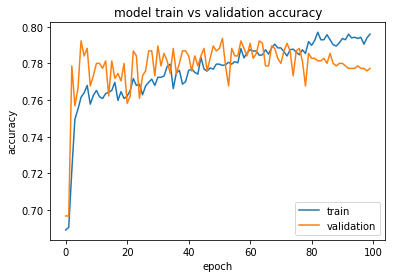

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.67      0.51      0.58       222
          1       0.81      0.89      0.85       510

avg / total       0.77      0.78      0.77       732

Accuracy score: 0.777322404372
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.66      0.50      0.57       349
          1       0.85      0.92      0.89      1117

avg / total       0.81      0.82      0.81      1466

Accuracy score: 0.819236016371


In [143]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile2, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile2.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile2)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 3

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 30s 10ms/step - loss: 0.6231 - acc: 0.6905 - val_loss: 0.6145 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 10s 4ms/step - loss: 0.6136 - acc: 0.6905 - val_loss: 0.5662 - val_acc: 0.6967
Epoch 3/100
2927/2927 [==============================] - 11s 4ms/step - loss: 0.5205 - acc: 0.7438 - val_loss: 0.5059 - val_acc: 0.7514
Epoch 4/100
2927/2927 [==============================] - 10s 4ms/step - loss: 0.5074 - acc: 0.7509 - val_loss: 0.5027 - val_acc: 0.7596
Epoch 5/100
2927/2927 [==============================] - 11s 4ms/step - loss: 0.4984 - acc: 0.7649 - val_loss: 0.4603 - val_acc: 0.7814
Epoch 6/100
2927/2927 [==============================] - 11s 4ms/step - loss: 0.5013 - acc: 0.7523 - val_loss: 0.4767 - val_acc: 0.7732
Epoch 7/100
2927/2927 [==============================] - 11s 4ms/step - loss: 0.5023 - acc: 0.758

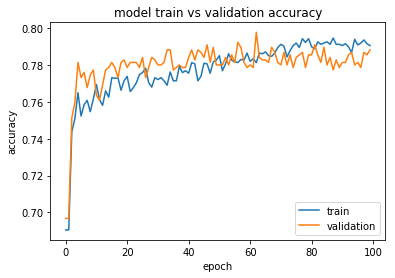

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.50      0.59       222
          1       0.81      0.91      0.86       510

avg / total       0.78      0.79      0.78       732

Accuracy score: 0.78825136612
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.68      0.52      0.59       349
          1       0.86      0.92      0.89      1117

avg / total       0.82      0.83      0.82      1466

Accuracy score: 0.827421555252


In [144]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile3, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile3.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile3)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 4

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 32s 11ms/step - loss: 0.6215 - acc: 0.6905 - val_loss: 0.6123 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 12s 4ms/step - loss: 0.5371 - acc: 0.7311 - val_loss: 0.4304 - val_acc: 0.8279
Epoch 3/100
2927/2927 [==============================] - 12s 4ms/step - loss: 0.4732 - acc: 0.7779 - val_loss: 0.5211 - val_acc: 0.7363
Epoch 4/100
2927/2927 [==============================] - 12s 4ms/step - loss: 0.4489 - acc: 0.8053 - val_loss: 0.4065 - val_acc: 0.8320
Epoch 5/100
2927/2927 [==============================] - 12s 4ms/step - loss: 0.4649 - acc: 0.7854 - val_loss: 0.4096 - val_acc: 0.8156
Epoch 6/100
2927/2927 [==============================] - 12s 4ms/step - loss: 0.4476 - acc: 0.7988 - val_loss: 0.4145 - val_acc: 0.8197
Epoch 7/100
2927/2927 [==============================] - 12s 4ms/step - loss: 0.4388 - acc: 0.808

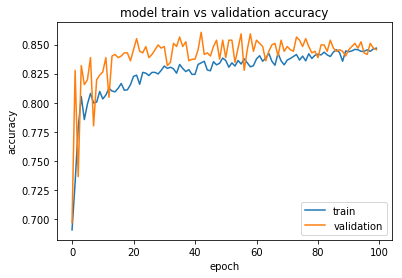

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.80      0.65      0.72       222
          1       0.86      0.93      0.89       510

avg / total       0.84      0.85      0.84       732

Accuracy score: 0.845628415301
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.77      0.61      0.68       349
          1       0.89      0.94      0.91      1117

avg / total       0.86      0.86      0.86      1466

Accuracy score: 0.864256480218


In [145]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile4, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile4.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile4)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 5

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 36s 12ms/step - loss: 0.6207 - acc: 0.6905 - val_loss: 0.6135 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 15s 5ms/step - loss: 0.5767 - acc: 0.7151 - val_loss: 0.4294 - val_acc: 0.8128
Epoch 3/100
2927/2927 [==============================] - 15s 5ms/step - loss: 0.4153 - acc: 0.8278 - val_loss: 0.3917 - val_acc: 0.8279
Epoch 4/100
2927/2927 [==============================] - 15s 5ms/step - loss: 0.4051 - acc: 0.8333 - val_loss: 0.3828 - val_acc: 0.8402
Epoch 5/100
2927/2927 [==============================] - 14s 5ms/step - loss: 0.3943 - acc: 0.8418 - val_loss: 0.3827 - val_acc: 0.8361
Epoch 6/100
2927/2927 [==============================] - 14s 5ms/step - loss: 0.4046 - acc: 0.8333 - val_loss: 0.4074 - val_acc: 0.8361
Epoch 7/100
2927/2927 [==============================] - 14s 5ms/step - loss: 0.3996 - acc: 0.839

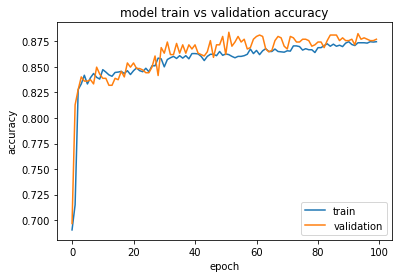

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.82      0.76      0.79       222
          1       0.90      0.93      0.91       510

avg / total       0.88      0.88      0.88       732

Accuracy score: 0.877049180328
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.69      0.74      0.71       349
          1       0.92      0.90      0.91      1117

avg / total       0.86      0.86      0.86      1466

Accuracy score: 0.859481582538


In [146]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile5, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile5.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile5)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 6

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 42s 14ms/step - loss: 0.6231 - acc: 0.6864 - val_loss: 0.6128 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 19s 7ms/step - loss: 0.5495 - acc: 0.7202 - val_loss: 0.3698 - val_acc: 0.8443
Epoch 3/100
2927/2927 [==============================] - 20s 7ms/step - loss: 0.4076 - acc: 0.8241 - val_loss: 0.3547 - val_acc: 0.8620
Epoch 4/100
2927/2927 [==============================] - 19s 6ms/step - loss: 0.4063 - acc: 0.8278 - val_loss: 0.3551 - val_acc: 0.8579
Epoch 5/100
2927/2927 [==============================] - 20s 7ms/step - loss: 0.4023 - acc: 0.8312 - val_loss: 0.4186 - val_acc: 0.8361
Epoch 6/100
2927/2927 [==============================] - 20s 7ms/step - loss: 0.3820 - acc: 0.8370 - val_loss: 0.3761 - val_acc: 0.8511
Epoch 7/100
2927/2927 [==============================] - 19s 7ms/step - loss: 0.3871 - acc: 0.832

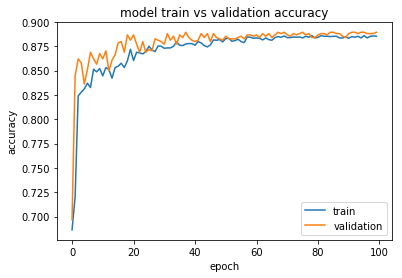

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.86      0.76      0.81       222
          1       0.90      0.95      0.92       510

avg / total       0.89      0.89      0.89       732

Accuracy score: 0.889344262295
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.81      0.72      0.76       349
          1       0.91      0.95      0.93      1117

avg / total       0.89      0.89      0.89      1466

Accuracy score: 0.891541609823


In [147]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile6, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile6.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile6)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 7

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 41s 14ms/step - loss: 0.6226 - acc: 0.6905 - val_loss: 0.6194 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 20s 7ms/step - loss: 0.5626 - acc: 0.7260 - val_loss: 0.3515 - val_acc: 0.8634
Epoch 3/100
2927/2927 [==============================] - 20s 7ms/step - loss: 0.3700 - acc: 0.8514 - val_loss: 0.3266 - val_acc: 0.8689
Epoch 4/100
2927/2927 [==============================] - 21s 7ms/step - loss: 0.3557 - acc: 0.8613 - val_loss: 0.3854 - val_acc: 0.8415
Epoch 5/100
2927/2927 [==============================] - 21s 7ms/step - loss: 0.3337 - acc: 0.8732 - val_loss: 0.2902 - val_acc: 0.8962
Epoch 6/100
2927/2927 [==============================] - 21s 7ms/step - loss: 0.3256 - acc: 0.8743 - val_loss: 0.3129 - val_acc: 0.8839
Epoch 7/100
2927/2927 [==============================] - 20s 7ms/step - loss: 0.3224 - acc: 0.879

2927/2927 [==============================] - 23s 8ms/step - loss: 0.2470 - acc: 0.8978 - val_loss: 0.2190 - val_acc: 0.9071
Epoch 60/100
2927/2927 [==============================] - 22s 8ms/step - loss: 0.2481 - acc: 0.8999 - val_loss: 0.2182 - val_acc: 0.9057
Epoch 61/100
2927/2927 [==============================] - 22s 8ms/step - loss: 0.2497 - acc: 0.8975 - val_loss: 0.2362 - val_acc: 0.9098
Epoch 62/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.2478 - acc: 0.8999 - val_loss: 0.2210 - val_acc: 0.9139
Epoch 63/100
2927/2927 [==============================] - 22s 8ms/step - loss: 0.2469 - acc: 0.8968 - val_loss: 0.2307 - val_acc: 0.9139
Epoch 64/100
2927/2927 [==============================] - 22s 8ms/step - loss: 0.2471 - acc: 0.8982 - val_loss: 0.2251 - val_acc: 0.9180
Epoch 65/100
2927/2927 [==============================] - 22s 7ms/step - loss: 0.2465 - acc: 0.8978 - val_loss: 0.2189 - val_acc: 0.9194

Epoch 00065: ReduceLROnPlateau reducing learning rate

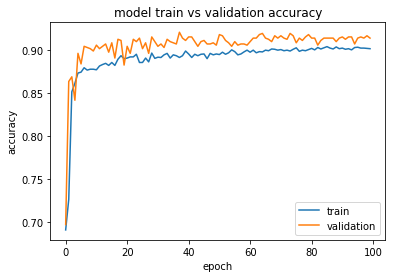

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.87      0.84      0.86       222
          1       0.93      0.95      0.94       510

avg / total       0.91      0.91      0.91       732

Accuracy score: 0.91393442623
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.66      0.87      0.75       349
          1       0.95      0.86      0.90      1117

avg / total       0.88      0.86      0.87      1466

Accuracy score: 0.859481582538


In [148]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile7, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile7.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile7)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 8

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 48s 16ms/step - loss: 0.6357 - acc: 0.6734 - val_loss: 0.6175 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.6178 - acc: 0.6905 - val_loss: 0.6058 - val_acc: 0.6967
Epoch 3/100
2927/2927 [==============================] - 25s 9ms/step - loss: 0.6057 - acc: 0.6956 - val_loss: 0.6084 - val_acc: 0.6967
Epoch 4/100
2927/2927 [==============================] - 26s 9ms/step - loss: 0.5260 - acc: 0.7468 - val_loss: 0.2990 - val_acc: 0.8962
Epoch 5/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.3366 - acc: 0.8726 - val_loss: 0.2770 - val_acc: 0.9003
Epoch 6/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.3178 - acc: 0.8821 - val_loss: 0.2745 - val_acc: 0.9016
Epoch 7/100
2927/2927 [==============================] - 25s 9ms/step - loss: 0.3179 - acc: 0.878

2927/2927 [==============================] - 25s 9ms/step - loss: 0.2296 - acc: 0.9006 - val_loss: 0.2227 - val_acc: 0.9057
Epoch 60/100
2927/2927 [==============================] - 25s 9ms/step - loss: 0.2300 - acc: 0.9019 - val_loss: 0.2125 - val_acc: 0.9153
Epoch 61/100
2927/2927 [==============================] - 25s 9ms/step - loss: 0.2368 - acc: 0.9009 - val_loss: 0.2226 - val_acc: 0.9112
Epoch 62/100
2927/2927 [==============================] - 25s 9ms/step - loss: 0.2322 - acc: 0.9009 - val_loss: 0.2199 - val_acc: 0.9098

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 63/100
2927/2927 [==============================] - 25s 8ms/step - loss: 0.2314 - acc: 0.9023 - val_loss: 0.2110 - val_acc: 0.9194
Epoch 64/100
2927/2927 [==============================] - 26s 9ms/step - loss: 0.2278 - acc: 0.9037 - val_loss: 0.2105 - val_acc: 0.9194
Epoch 65/100
2927/2927 [==============================] - 25s 8ms/step - loss: 0.2283 - acc: 0.9037 - val_loss

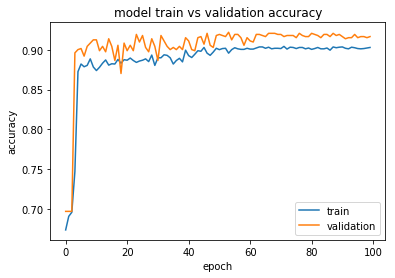

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.81      0.86       222
          1       0.92      0.96      0.94       510

avg / total       0.92      0.92      0.92       732

Accuracy score: 0.916666666667
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.87      0.79      0.83       349
          1       0.94      0.96      0.95      1117

avg / total       0.92      0.92      0.92      1466

Accuracy score: 0.921555252387


In [149]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile8, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile8.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile8)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 9

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/100
2927/2927 [==============================] - 50s 17ms/step - loss: 0.6215 - acc: 0.6905 - val_loss: 0.6118 - val_acc: 0.6967
Epoch 2/100
2927/2927 [==============================] - 27s 9ms/step - loss: 0.4504 - acc: 0.8008 - val_loss: 0.4093 - val_acc: 0.8060
Epoch 3/100
2927/2927 [==============================] - 25s 9ms/step - loss: 0.3188 - acc: 0.8763 - val_loss: 0.2864 - val_acc: 0.9098
Epoch 4/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.2939 - acc: 0.8955 - val_loss: 0.2560 - val_acc: 0.9071
Epoch 5/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.2928 - acc: 0.8965 - val_loss: 0.2826 - val_acc: 0.8907
Epoch 6/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.3034 - acc: 0.8917 - val_loss: 0.2636 - val_acc: 0.9030
Epoch 7/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.2783 - acc: 0.901

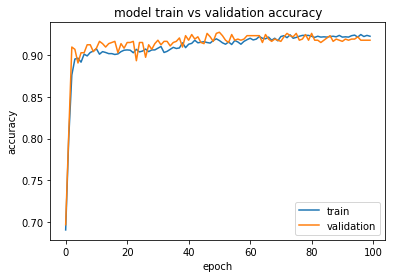

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.94      0.78      0.85       222
          1       0.91      0.98      0.94       510

avg / total       0.92      0.92      0.92       732

Accuracy score: 0.918032786885
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.83      0.86       349
          1       0.95      0.97      0.96      1117

avg / total       0.94      0.94      0.94      1466

Accuracy score: 0.93792633015


In [150]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_Decile9, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(FFF_Train_Decile9.shape[1],3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.000001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_Decile9)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

### FFF Decile 10

Fit LSTM Course FFF - 2 Target Classes
Train on 2927 samples, validate on 732 samples
Epoch 1/70
2927/2927 [==============================] - 29s 10ms/step - loss: 0.6152 - acc: 0.6891 - val_loss: 0.5877 - val_acc: 0.8989
Epoch 2/70
2927/2927 [==============================] - 23s 8ms/step - loss: 0.5440 - acc: 0.7421 - val_loss: 0.3416 - val_acc: 0.8661
Epoch 3/70
2927/2927 [==============================] - 23s 8ms/step - loss: 0.3831 - acc: 0.8432 - val_loss: 0.3576 - val_acc: 0.8675
Epoch 4/70
2927/2927 [==============================] - 24s 8ms/step - loss: 0.3558 - acc: 0.8664 - val_loss: 0.2840 - val_acc: 0.8975
Epoch 5/70
2927/2927 [==============================] - 24s 8ms/step - loss: 0.3248 - acc: 0.8767 - val_loss: 0.4405 - val_acc: 0.8115
Epoch 6/70
2927/2927 [==============================] - 24s 8ms/step - loss: 0.3217 - acc: 0.8750 - val_loss: 0.2750 - val_acc: 0.8948
Epoch 7/70
2927/2927 [==============================] - 26s 9ms/step - loss: 0.3083 - acc: 0.8855 - val

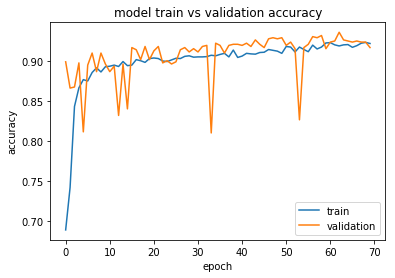

-------------------------------------------
Validate LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.98      0.74      0.84       222
          1       0.90      0.99      0.94       510

avg / total       0.92      0.92      0.91       732

Accuracy score: 0.916666666667
-------------------------------------------
Test LSTM Course FFF - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.96      0.76      0.85       349
          1       0.93      0.99      0.96      1117

avg / total       0.94      0.94      0.93      1466

Accuracy score: 0.93519781719


In [73]:
# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(FFF_Train_3D, FFF_Train_Targets_1D, test_size=0.20, random_state=7)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

FFF_model = Sequential()
FFF_model.add(Masking(mask_value=-1, input_shape =(293,3) ))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid', return_sequences = True))
FFF_model.add(LSTM(32, activation='sigmoid'))
FFF_model.add(Dense(1, activation='sigmoid'))

FFF_model.compile(optimizer=RMSprop(lr=0.005), loss='binary_crossentropy',metrics = ['accuracy'])
    
# Fit model for each timestep
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, verbose = 1, min_lr=0.00001, mode = "min", min_delta=0.001)
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1,
                       validation_data = (X_val, y_val), callbacks = [reduce_lr])

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
# Validate model
y_pred_FFF_val = FFF_model.predict(X_val)
y_classes_FFF_val = np.round(y_pred_FFF_val)
    
print('-------------------------------------------')
print('Validate LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF_val, y_true=y_val))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF_val, y_true=y_val)))


# Test model
y_pred_FFF = FFF_model.predict(FFF_Test_3D)
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))

## LSTM Course BBB

Fit LSTM Course BBB - 2 Target Classes
Train on 3708 samples, validate on 1490 samples
Epoch 1/300
3708/3708 [==============================] - 42s 11ms/step - loss: 0.7103 - acc: 0.2983 - val_loss: 0.7273 - val_acc: 0.2268
Epoch 2/300
3708/3708 [==============================] - 41s 11ms/step - loss: 0.7028 - acc: 0.3050 - val_loss: 0.7154 - val_acc: 0.2268
Epoch 3/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.6961 - acc: 0.4029 - val_loss: 0.7046 - val_acc: 0.2403
Epoch 4/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.6899 - acc: 0.6033 - val_loss: 0.6944 - val_acc: 0.4819
Epoch 5/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.6842 - acc: 0.6855 - val_loss: 0.6844 - val_acc: 0.7242
Epoch 6/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.6783 - acc: 0.7017 - val_loss: 0.6741 - val_acc: 0.7611
Epoch 7/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.6723 - acc

Epoch 60/300
3708/3708 [==============================] - 37s 10ms/step - loss: 0.4294 - acc: 0.7996 - val_loss: 0.5921 - val_acc: 0.6208
Epoch 61/300
3708/3708 [==============================] - 37s 10ms/step - loss: 0.4259 - acc: 0.7991 - val_loss: 0.5904 - val_acc: 0.6242
Epoch 62/300
3708/3708 [==============================] - 37s 10ms/step - loss: 0.4236 - acc: 0.8034 - val_loss: 0.5902 - val_acc: 0.6282
Epoch 63/300
3708/3708 [==============================] - 38s 10ms/step - loss: 0.4209 - acc: 0.8064 - val_loss: 0.5884 - val_acc: 0.6329
Epoch 64/300
3708/3708 [==============================] - 38s 10ms/step - loss: 0.4179 - acc: 0.8088 - val_loss: 0.5762 - val_acc: 0.6463
Epoch 65/300
3708/3708 [==============================] - 38s 10ms/step - loss: 0.4166 - acc: 0.8085 - val_loss: 0.5918 - val_acc: 0.6289
Epoch 66/300
3708/3708 [==============================] - 38s 10ms/step - loss: 0.4143 - acc: 0.8099 - val_loss: 0.5928 - val_acc: 0.6302
Epoch 67/300
3708/3708 [==========

3708/3708 [==============================] - 39s 11ms/step - loss: 0.2884 - acc: 0.8897 - val_loss: 0.3670 - val_acc: 0.8611
Epoch 179/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2882 - acc: 0.8910 - val_loss: 0.3745 - val_acc: 0.8584
Epoch 180/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2882 - acc: 0.8916 - val_loss: 0.3688 - val_acc: 0.8604
Epoch 181/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2875 - acc: 0.8905 - val_loss: 0.3917 - val_acc: 0.8517
Epoch 182/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2870 - acc: 0.8913 - val_loss: 0.3652 - val_acc: 0.8611
Epoch 183/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2871 - acc: 0.8910 - val_loss: 0.3833 - val_acc: 0.8544
Epoch 184/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2867 - acc: 0.8913 - val_loss: 0.3720 - val_acc: 0.8597
Epoch 185/300
3708/3708 [================

3708/3708 [==============================] - 39s 10ms/step - loss: 0.2771 - acc: 0.8948 - val_loss: 0.3740 - val_acc: 0.8517
Epoch 238/300
3708/3708 [==============================] - 39s 10ms/step - loss: 0.2778 - acc: 0.8959 - val_loss: 0.4061 - val_acc: 0.8383
Epoch 239/300
3708/3708 [==============================] - 39s 10ms/step - loss: 0.2763 - acc: 0.8962 - val_loss: 0.3624 - val_acc: 0.8591
Epoch 240/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2772 - acc: 0.8959 - val_loss: 0.3922 - val_acc: 0.8416
Epoch 241/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2770 - acc: 0.8967 - val_loss: 0.3896 - val_acc: 0.8423
Epoch 242/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2757 - acc: 0.8943 - val_loss: 0.3490 - val_acc: 0.8591
Epoch 243/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2773 - acc: 0.8935 - val_loss: 0.3746 - val_acc: 0.8477
Epoch 244/300
3708/3708 [================

3708/3708 [==============================] - 39s 11ms/step - loss: 0.2688 - acc: 0.8970 - val_loss: 0.3760 - val_acc: 0.8416
Epoch 297/300
3708/3708 [==============================] - 40s 11ms/step - loss: 0.2695 - acc: 0.8972 - val_loss: 0.3906 - val_acc: 0.8416
Epoch 298/300
3708/3708 [==============================] - 41s 11ms/step - loss: 0.2683 - acc: 0.8970 - val_loss: 0.3741 - val_acc: 0.8430
Epoch 299/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2691 - acc: 0.8970 - val_loss: 0.3788 - val_acc: 0.8423
Epoch 300/300
3708/3708 [==============================] - 39s 11ms/step - loss: 0.2688 - acc: 0.8978 - val_loss: 0.3786 - val_acc: 0.8423


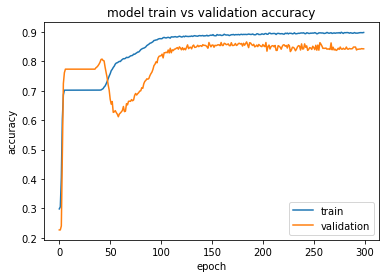

-------------------------------------------
Test LSTM Course BBB - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.61      0.83      0.70       338
          1       0.94      0.85      0.89      1152

avg / total       0.87      0.84      0.85      1490

Accuracy score: 0.842281879195


In [44]:

LSTM_input = Input(shape=(293,3), name='LSTM_input')
Mask = Masking(mask_value=-1)(LSTM_input)
LSTM_hidden1 = LSTM(32,return_sequences=True)(Mask)
LSTM_hidden2 = LSTM(32,return_sequences=True)(LSTM_hidden1)
LSTM_hidden3 = LSTM(32,return_sequences=True)(LSTM_hidden2)
#LSTM_hidden4 = LSTM(32,return_sequences=True)(LSTM_hidden3)
LSTM_out = LSTM(32)(LSTM_hidden3)

auxiliary_input = Input(shape=(29,), name='aux_input')
auxiliary_layer = Dense(64, activation='relu')(auxiliary_input)
auxiliary_output = Dense(32, activation='relu')(auxiliary_layer)

x = keras.layers.concatenate([LSTM_out, auxiliary_output])


x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

BBB_model = Model(inputs=[LSTM_input, auxiliary_input], outputs=main_output)
BBB_model.compile(optimizer=RMSprop(lr=0.000007), loss='binary_crossentropy',metrics = ['accuracy'])
    
    # Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=0, verbose=0, mode='auto')
print('Fit LSTM Course BBB - 2 Target Classes')
    
history = BBB_model.fit([BBB_Train_3D,BBB_AUX_Train], BBB_Train_Targets_1D, epochs=300, batch_size=32, verbose=1,
                       validation_data = ([BBB_Test_3D, BBB_AUX_Test], BBB_Test_Targets_1D))

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
    # Test model for each timestep
y_pred_BBB = BBB_model.predict([BBB_Test_3D, BBB_AUX_Test])
y_classes_BBB = np.round(y_pred_BBB)
    
print('-------------------------------------------')
print('Test LSTM Course BBB - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_BBB, y_true=BBB_Test_Targets_1D)))

Fit LSTM Course DDD - 2 Target Classes
Train on 2687 samples, validate on 1121 samples
Epoch 1/300
2687/2687 [==============================] - 29s 11ms/step - loss: 0.6983 - acc: 0.3796 - val_loss: 0.6956 - val_acc: 0.4630
Epoch 2/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.6928 - acc: 0.4968 - val_loss: 0.6893 - val_acc: 0.5968
Epoch 3/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.6871 - acc: 0.6357 - val_loss: 0.6831 - val_acc: 0.6744
Epoch 4/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.6817 - acc: 0.6758 - val_loss: 0.6771 - val_acc: 0.7065
Epoch 5/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.6766 - acc: 0.6766 - val_loss: 0.6715 - val_acc: 0.7065
Epoch 6/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.6714 - acc: 0.6766 - val_loss: 0.6660 - val_acc: 0.7065
Epoch 7/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.6661 - acc

Epoch 60/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.3896 - acc: 0.8504 - val_loss: 0.3721 - val_acc: 0.8394
Epoch 61/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.3872 - acc: 0.8485 - val_loss: 0.3704 - val_acc: 0.8394
Epoch 62/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.3848 - acc: 0.8523 - val_loss: 0.3685 - val_acc: 0.8403
Epoch 63/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.3826 - acc: 0.8508 - val_loss: 0.3669 - val_acc: 0.8412
Epoch 64/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.3806 - acc: 0.8493 - val_loss: 0.3656 - val_acc: 0.8403
Epoch 65/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.3785 - acc: 0.8515 - val_loss: 0.3645 - val_acc: 0.8412
Epoch 66/300
2687/2687 [==============================] - 27s 10ms/step - loss: 0.3767 - acc: 0.8523 - val_loss: 0.3631 - val_acc: 0.8448
Epoch 67/300
2687/2687 [==========

2687/2687 [==============================] - 28s 10ms/step - loss: 0.2635 - acc: 0.8895 - val_loss: 0.3102 - val_acc: 0.8680
Epoch 179/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2631 - acc: 0.8884 - val_loss: 0.3096 - val_acc: 0.8698
Epoch 180/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2627 - acc: 0.8880 - val_loss: 0.3099 - val_acc: 0.8671
Epoch 181/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2622 - acc: 0.8872 - val_loss: 0.3122 - val_acc: 0.8689
Epoch 182/300
2687/2687 [==============================] - 28s 11ms/step - loss: 0.2625 - acc: 0.8876 - val_loss: 0.3122 - val_acc: 0.8662
Epoch 183/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2620 - acc: 0.8887 - val_loss: 0.3131 - val_acc: 0.8680
Epoch 184/300
2687/2687 [==============================] - 28s 11ms/step - loss: 0.2614 - acc: 0.8884 - val_loss: 0.3111 - val_acc: 0.8671
Epoch 185/300
2687/2687 [================

2687/2687 [==============================] - 28s 10ms/step - loss: 0.2513 - acc: 0.8895 - val_loss: 0.3165 - val_acc: 0.8715
Epoch 238/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2503 - acc: 0.8884 - val_loss: 0.3145 - val_acc: 0.8680
Epoch 239/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2500 - acc: 0.8887 - val_loss: 0.3160 - val_acc: 0.8715
Epoch 240/300
2687/2687 [==============================] - 29s 11ms/step - loss: 0.2497 - acc: 0.8884 - val_loss: 0.3142 - val_acc: 0.8671
Epoch 241/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2498 - acc: 0.8887 - val_loss: 0.3224 - val_acc: 0.8671
Epoch 242/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2496 - acc: 0.8910 - val_loss: 0.3152 - val_acc: 0.8715
Epoch 243/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2494 - acc: 0.8891 - val_loss: 0.3223 - val_acc: 0.8671
Epoch 244/300
2687/2687 [================

2687/2687 [==============================] - 28s 10ms/step - loss: 0.2433 - acc: 0.8898 - val_loss: 0.3175 - val_acc: 0.8698
Epoch 297/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2437 - acc: 0.8910 - val_loss: 0.3233 - val_acc: 0.8707
Epoch 298/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2437 - acc: 0.8910 - val_loss: 0.3178 - val_acc: 0.8724
Epoch 299/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2431 - acc: 0.8906 - val_loss: 0.3196 - val_acc: 0.8724
Epoch 300/300
2687/2687 [==============================] - 28s 10ms/step - loss: 0.2431 - acc: 0.8910 - val_loss: 0.3145 - val_acc: 0.8715


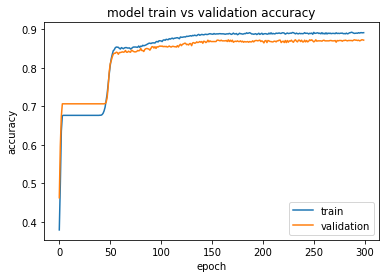

-------------------------------------------
Test LSTM Course DDD - 2 Target Classes
Classification Report for LSTM predictions:
-------------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.62      0.74       329
          1       0.86      0.97      0.91       792

avg / total       0.88      0.87      0.86      1121

Accuracy score: 0.871543264942


In [45]:

LSTM_input = Input(shape=(293,3), name='LSTM_input')
Mask = Masking(mask_value=-1)(LSTM_input)
LSTM_hidden1 = LSTM(32,return_sequences=True)(Mask)
LSTM_hidden2 = LSTM(32,return_sequences=True)(LSTM_hidden1)
LSTM_hidden3 = LSTM(32,return_sequences=True)(LSTM_hidden2)
#LSTM_hidden4 = LSTM(32,return_sequences=True)(LSTM_hidden3)
LSTM_out = LSTM(32)(LSTM_hidden3)

auxiliary_input = Input(shape=(29,), name='aux_input')
auxiliary_layer = Dense(64, activation='relu')(auxiliary_input)
auxiliary_output = Dense(32, activation='relu')(auxiliary_layer)

x = keras.layers.concatenate([LSTM_out, auxiliary_output])


x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

DDD_model = Model(inputs=[LSTM_input, auxiliary_input], outputs=main_output)
DDD_model.compile(optimizer=RMSprop(lr=0.000007), loss='binary_crossentropy',metrics = ['accuracy'])
    
    # Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=0, verbose=0, mode='auto')
print('Fit LSTM Course DDD - 2 Target Classes')
    
history = DDD_model.fit([DDD_Train_3D,DDD_AUX_Train], DDD_Train_Targets_1D, epochs=300, batch_size=32, verbose=1,
                       validation_data = ([DDD_Test_3D, DDD_AUX_Test], DDD_Test_Targets_1D))

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
    # Test model for each timestep
y_pred_DDD = DDD_model.predict([DDD_Test_3D, DDD_AUX_Test])
y_classes_DDD = np.round(y_pred_DDD)
    
print('-------------------------------------------')
print('Test LSTM Course DDD - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_DDD, y_true=DDD_Test_Targets_1D)))
    

In [48]:

LSTM_input = Input(shape=(293,3), name='LSTM_input')
Mask = Masking(mask_value=-1)(LSTM_input)
LSTM_hidden1 = LSTM(32,return_sequences=True)(Mask)
LSTM_hidden2 = LSTM(32,return_sequences=True)(LSTM_hidden1)
LSTM_hidden3 = LSTM(32,return_sequences=True)(LSTM_hidden2)
#LSTM_hidden4 = LSTM(32,return_sequences=True)(LSTM_hidden3)
LSTM_out = LSTM(32)(LSTM_hidden3)

auxiliary_input = Input(shape=(29,), name='aux_input')
auxiliary_layer = Dense(64, activation='relu')(auxiliary_input)
auxiliary_output = Dense(32, activation='relu')(auxiliary_layer)

x = keras.layers.concatenate([LSTM_out, auxiliary_output])


x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

FFF_model = Model(inputs=[LSTM_input, auxiliary_input], outputs=main_output)
FFF_model.compile(optimizer=RMSprop(lr=0.000005), loss='binary_crossentropy',metrics = ['accuracy'])
    
    # Fit model for each timestep
ES = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
print('Fit LSTM Course FFF - 2 Target Classes')
    
history = FFF_model.fit([FFF_Train_3D,FFF_AUX_Train], FFF_Train_Targets_1D, epochs=300, batch_size=32, verbose=1,
                       validation_data = ([FFF_Test_3D, FFF_AUX_Test], FFF_Test_Targets_1D))

# plot train vs validation accuracy
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()
    
    # Test model for each timestep
y_pred_FFF = FFF_model.predict([FFF_Test_3D, FFF_AUX_Test])
y_classes_FFF = np.round(y_pred_FFF)
    
print('-------------------------------------------')
print('Test LSTM Course FFF - 2 Target Classes')
print('Classification Report for LSTM predictions:')
print('-------------------------------------------')
print(classification_report(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D))
print("Accuracy score: " + str(accuracy_score(y_pred=y_classes_FFF, y_true=FFF_Test_Targets_1D)))
    

Fit LSTM Course FFF - 2 Target Classes
Train on 3659 samples, validate on 1466 samples
Epoch 1/300
3659/3659 [==============================] - 43s 12ms/step - loss: 0.6965 - acc: 0.4026 - val_loss: 0.6949 - val_acc: 0.4188
Epoch 2/300
3659/3659 [==============================] - 39s 11ms/step - loss: 0.6958 - acc: 0.4250 - val_loss: 0.6940 - val_acc: 0.4570
Epoch 3/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6950 - acc: 0.4523 - val_loss: 0.6931 - val_acc: 0.4986
Epoch 4/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6943 - acc: 0.4816 - val_loss: 0.6923 - val_acc: 0.5334
Epoch 5/300
3659/3659 [==============================] - 40s 11ms/step - loss: 0.6936 - acc: 0.4960 - val_loss: 0.6914 - val_acc: 0.5723
Epoch 6/300
3659/3659 [==============================] - 39s 11ms/step - loss: 0.6928 - acc: 0.5141 - val_loss: 0.6905 - val_acc: 0.6085
Epoch 7/300
3659/3659 [==============================] - 40s 11ms/step - loss: 0.6921 - acc

Epoch 60/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6420 - acc: 0.6917 - val_loss: 0.6208 - val_acc: 0.7619
Epoch 61/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6407 - acc: 0.6917 - val_loss: 0.6188 - val_acc: 0.7619
Epoch 62/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6395 - acc: 0.6917 - val_loss: 0.6169 - val_acc: 0.7619
Epoch 63/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6382 - acc: 0.6917 - val_loss: 0.6150 - val_acc: 0.7619
Epoch 64/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6369 - acc: 0.6917 - val_loss: 0.6130 - val_acc: 0.7619
Epoch 65/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6357 - acc: 0.6917 - val_loss: 0.6110 - val_acc: 0.7619
Epoch 66/300
3659/3659 [==============================] - 38s 10ms/step - loss: 0.6344 - acc: 0.6917 - val_loss: 0.6090 - val_acc: 0.7619
Epoch 67/300
3659/3659 [==========

KeyboardInterrupt: 